<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      #n_a_dts = S_dict['n_a_dts']
      #a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      #a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_dts'] == 0):
        n_a_dts, a_d_dts_max, a_d_dts_min = 1, 0, 0
      else:
        n_a_dts = S_dict['n_a_dts']
        a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
        a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      print("S_dts_inv in get path, ridge regression \n", S_dict['S_dts'])
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, 0])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 2.00570628 -0.99818235 -0.00674327  0.00748903]
intercpt  -0.016602252840644746
coef :  [ 2.00570628 -0.99818235 -0.00674327  0.00748903]
intercpt  -0.016602252840644746
coef :  [ 2.00568936 -0.99817682 -0.00673925  0.00749112]
intercpt  -0.016603636496644494
coef :  [ 2.00568936 -0.99817682 -0.00673925  0.00749112]
intercpt  -0.016603636496644494
coef :  [ 2.00399851 -0.99762466 -0.00633819  0.00769925]
intercpt  -0.01674194936033276
coef :  [ 2.00399851 -0.99762466 -0.00633819  0.00769925]
intercpt  -0.01674194936033276
coef :  [ 1.98879237 -0.99259187 -0.00266045  0.00959587]
intercpt  -0.018014986962789154
coef :  [ 1.98879237 -0.99259187 -0.00266045  0.00959587]
intercpt  -0.018014986962789154
end block


In [ ]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  print("X shape in clear data ", X.shape)
  print("y shape in clear data ", y.shape)
  print("M shape in clear data ", M.shape)
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [ ]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][-1]  # last one should be the biggest one
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [25]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
      elif info['cov_strategy_between'] == 'zero':
        d = dict_observations['X_test'].shape[-1]
        S_mis = np.zeros((d, d))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'LogNormal':
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.lognormal(mean=data['mean'], sigma=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'Logistic':
      X_complete = np.random.logistic(loc=0.0, scale=1.0, size=(n_tot, dim))
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_full_seen (train): ", np.sum(M == 0), " nbr_at_least_one_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#     print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
    #print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)



In [33]:
def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_hyper_p':[], 'best_alpha_dts':[], 'best_alpha_mis':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][-1],  # last one should be the biggest
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][-1],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          n_train = dictio['n_train']
          print("n_tot_fll ", n_train, ",  ", n_train[i])
          #print(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :].shape)
          #print(dictio_obser_fixed_copy['X_train_masked'][0].shape)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :], dictio_obser_fixed_copy['y_train'][0:n_train[i]], full_masks[i][0:n_train[i], :])
          print("shapes X_train cleaned, mask train cleaned, y train cleaned")
          print(X_train_cleaned.shape)
          print(masks_train_cleaned.shape)
          print(y_train_cleaned.shape)
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_hyper_p'].append(hyper_p_round)  # both hyperparameters
        res[key_tuple]['best_alpha_dts'].append(hyper_p_round[0])  # one of the hyperparameter
        res[key_tuple]['best_alpha_mis'].append(hyper_p_round[1])  # the other hyperparameter

        #res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  lb = extra_info['what_to_plot']
  nbr_plot = len(lb)
  fig_res, ax_res = plt.subplots(1, nbr_plot,
                                 figsize=(45 * (nbr_plot / 3 ), 7.5))  # , num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key in plot_res", key, ": values\n", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  # lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(nbr_plot):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      print("lb[i] in plot_res ", lb[i], "  ", dictio[lb[i]])
      print("key: ", key)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key), color=key[-1])  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=20,)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2", fontweight='bold', fontsize=16)
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test", fontweight='bold', fontsize=16)
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'], fontweight='bold', fontsize = 24)
  ax_res[1].set_title(extra_info['title_test_error'], fontweight='bold', fontsize = 24)
  ax_res[2].set_title(extra_info['title_dts_radius'], fontweight='bold', fontsize = 24)
  ax_res[3].set_title(extra_info['title_mis_radius'], fontweight='bold', fontsize = 24)
  ax_res[2].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  ax_res[3].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      print("res partial \n")
      for k, value in res_partial.items():
        print("key: ", k, " value: ", value)
      plot_res(info_x_axis, res_partial, dictio)
      print("res in run multipl experiments\n")
#      for k, value in res.items():
#        print("key: ", k, " value: ", value)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_hyper_p'].append(res_partial[k]['best_hyper_p'])
        res[k]['best_alpha_dts'].append(res_partial[k]['best_alpha_dts'])
        res[k]['best_alpha_mis'].append(res_partial[k]['best_alpha_mis'])

        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3.50413873,  1.30301027,  1.0064988 , -1.76321956],
       [ 2.60020248, -0.74497351, -1.80787057,  7.93440241, -0.92584153,
        -0.42015486,  3.87999875, -1.04337576,  0.63119197,  4.24806161],
       [ 0.35031866,  0.41905191,  2.40016108, -0.92584153,  3.12785508,
        -1.46014401,  1.25511888,  2.2639915 ,  1.00252064, -1.31042245],
      

100%|██████████| 1/1 [00:00<00:00, 38.13it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.31047199323222e-28
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.71587854 1.15733259 1.0859997  1.10773771 1.0422987  0.95485003
 0.91824123 1.05682983 0.96414681 1.21014159]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -264.7467626440647
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (21, 10, 10)
S missing
  [[[1.4653825  0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         2.82974583 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 3.00584335 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         2.10491807]]

 [[0.         0.         0.         .

100%|██████████| 1/1 [00:00<00:00, 44.36it/s]

100%|██████████| 1/1 [00:00<00:00, 91.97it/s]

100%|██████████| 1/1 [00:00<00:00, 63.51it/s]

100%|██████████| 1/1 [00:00<00:00, 71.91it/s]

100%|██████████| 1/1 [00:00<00:00, 58.87it/s]

100%|██████████| 1/1 [00:00<00:00, 66.22it/s]

100%|██████████| 1/1 [00:00<00:00, 72.27it/s]

100%|██████████| 1/1 [00:00<00:00, 71.01it/s]

100%|██████████| 1/1 [00:00<00:00, 67.14it/s]

100%|██████████| 1/1 [00:00<00:00, 90.81it/s]

100%|██████████| 1/1 [00:00<00:00, 66.86it/s]

100%|██████████| 1/1 [00:00<00:00, 90.48it/s]

100%|██████████| 1/1 [00:00<00:00, 107.85it/s]

100%|██████████| 1/1 [00:00<00:00, 64.21it/s]

100%|██████████| 1/1 [00:00<00:00, 64.22it/s]

100%|██████████| 1/1 [00:00<00:00, 82.28it/s]

100%|██████████| 1/1 [00:00<00:00, 102.61it/s]

100%|██████████| 1/1 [00:00<00:00, 93.71it/s]

100%|██████████| 1/1 [00:00<00:00, 55.43it/s]

100%|██████████| 1/1 [00:00<00:00, 79.75it/s]

100%|██████████| 1/1 [00:00<00:00, 71.63it/s]

100%|██████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.08531679] , min score  2.5168413042533677
---------------------------------> best coeff  [-1.01849440e+00 -8.98208096e-08 -2.91498104e-09 -2.91833665e-10
 -6.42499947e-10 -1.22971141e+00 -7.42055137e-01 -4.25386273e-01
 -2.40321796e-09  2.15308721e-09]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.71587854 1.15733259 1.0859997  1.10773771 1.0422987  0.95485003
 0.91824123 1.05682983 0.96414681 1.21014159]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -264.7467626440647
[7 8 8 8 9 9 6 8 7 5 9 

100%|██████████| 1/1 [00:00<00:00, 22.40it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  11.312078148543375
---------------------------------> best coeff  [-2.3563983  -1.39998542  1.27753915 -1.34536577  1.04046112 -1.69942058
 -1.38577408 -1.77879113 -1.26252176  0.17429394]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 33.66it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.945839478789226e-29
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.81432753 0.9405782  1.06822803 1.06128898 1.19615646 0.95885617
 0.96286923 1.05144002 0.89350797 1.14142074]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -126.57274395519511
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8 8 6 8 8 9 7 7 7 9 6 9 8 7 7 8 9
 8 9 

100%|██████████| 1/1 [00:00<00:00, 29.59it/s]

100%|██████████| 1/1 [00:00<00:00, 50.69it/s]

100%|██████████| 1/1 [00:00<00:00, 57.15it/s]

100%|██████████| 1/1 [00:00<00:00, 65.00it/s]

100%|██████████| 1/1 [00:00<00:00, 38.17it/s]

100%|██████████| 1/1 [00:00<00:00, 52.25it/s]

100%|██████████| 1/1 [00:00<00:00, 53.90it/s]

100%|██████████| 1/1 [00:00<00:00, 43.18it/s]

100%|██████████| 1/1 [00:00<00:00, 59.05it/s]

100%|██████████| 1/1 [00:00<00:00, 42.67it/s]

100%|██████████| 1/1 [00:00<00:00, 54.00it/s]

100%|██████████| 1/1 [00:00<00:00, 68.79it/s]

100%|██████████| 1/1 [00:00<00:00, 46.13it/s]

100%|██████████| 1/1 [00:00<00:00, 41.68it/s]

100%|██████████| 1/1 [00:00<00:00, 48.27it/s]

100%|██████████| 1/1 [00:00<00:00, 65.18it/s]

100%|██████████| 1/1 [00:00<00:00, 41.25it/s]

100%|██████████| 1/1 [00:00<00:00, 41.88it/s]

100%|██████████| 1/1 [00:00<00:00, 61.20it/s]

100%|██████████| 1/1 [00:00<00:00, 36.64it/s]

100%|██████████| 1/1 [00:00<00:00, 47.06it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.03290345] , min score  5.093581041258484
---------------------------------> best coeff  [ 3.44297339e-01  7.25229382e-11 -4.61557352e-01  9.50344286e-01
  1.96852244e-02 -3.99650615e-02  7.54585850e-02 -1.06513521e+00
 -7.95379927e-01 -2.74344835e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.81432753 0.9405782  1.06822803 1.06128898 1.19615646 0.95885617
 0.96286923 1.05144002 0.89350797 1.14142074]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -126.57274395519511
[7 8 8 8 9 9 6 8 7 5 9 

100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.855717878607521
---------------------------------> best coeff  [ 0.50516605  0.03072211 -0.41656717  0.90578088  0.25734299 -0.09624521
  0.41115215 -1.31654877 -1.30484273 -0.5445542 ]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 32.44it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.6406847491167186e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90032691 1.05722118 1.11429114 1.08279037 1.16240492 0.96470578
 0.95982638 1.0176183  0.85909465 1.04809669]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -174.10158090961966
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8 8 6 8 8 9 7 7 7 9 6 9 8 7 7 8 9
 8 9

100%|██████████| 1/1 [00:00<00:00, 14.44it/s]

100%|██████████| 1/1 [00:00<00:00, 27.72it/s]

100%|██████████| 1/1 [00:00<00:00, 24.73it/s]

100%|██████████| 1/1 [00:00<00:00, 24.80it/s]

100%|██████████| 1/1 [00:00<00:00, 21.20it/s]

100%|██████████| 1/1 [00:00<00:00, 28.66it/s]

100%|██████████| 1/1 [00:00<00:00, 28.40it/s]

100%|██████████| 1/1 [00:00<00:00, 27.46it/s]

100%|██████████| 1/1 [00:00<00:00, 26.95it/s]

100%|██████████| 1/1 [00:00<00:00, 31.54it/s]

100%|██████████| 1/1 [00:00<00:00, 27.15it/s]

100%|██████████| 1/1 [00:00<00:00, 30.64it/s]

100%|██████████| 1/1 [00:00<00:00, 23.98it/s]

100%|██████████| 1/1 [00:00<00:00, 24.14it/s]

100%|██████████| 1/1 [00:00<00:00, 25.02it/s]

100%|██████████| 1/1 [00:00<00:00, 27.62it/s]

100%|██████████| 1/1 [00:00<00:00, 26.59it/s]

100%|██████████| 1/1 [00:00<00:00, 26.12it/s]

100%|██████████| 1/1 [00:00<00:00, 23.69it/s]

100%|██████████| 30/30 [00:01<00:00, 22.79it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divi

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.05298317] , min score  3.177241081406232
---------------------------------> best coeff  [ 7.12658585e-03 -1.83681896e-09 -3.83143175e-01  3.04806113e-10
 -2.11583291e-01 -4.32923394e-01 -8.27806452e-04 -8.14792615e-01
 -1.47720567e-01  1.84685778e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90032691 1.05722118 1.11429114 1.08279037 1.16240492 0.96470578
 0.95982638 1.0176183  0.85909465 1.04809669]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -174.10158090961966
[7 8 8 8 9 9 6 8 7 5 9 

100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.639671487966984
---------------------------------> best coeff  [ 0.39595616 -0.00238294 -0.71367742 -0.07332522 -0.58760899 -1.10228934
 -0.03949931 -1.38113192  0.04070581  0.8282984 ]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 20.72it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.2142103782939876e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9158426  1.05945273 1.10729441 1.05676214 1.11223123 1.02526314
 0.92498184 1.03335322 0.83839665 1.01219388]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -232.72498456032446
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8 8 6 8 8 9 7 7 7 9 6 9 8 7 7 8 9
 8 9

100%|██████████| 1/1 [00:00<00:00, 20.45it/s]

100%|██████████| 1/1 [00:00<00:00, 25.57it/s]

100%|██████████| 1/1 [00:00<00:00, 28.12it/s]

100%|██████████| 1/1 [00:00<00:00, 30.53it/s]

100%|██████████| 1/1 [00:00<00:00, 23.44it/s]

100%|██████████| 1/1 [00:00<00:00, 24.94it/s]

100%|██████████| 1/1 [00:00<00:00, 23.25it/s]

100%|██████████| 1/1 [00:00<00:00, 18.31it/s]

100%|██████████| 1/1 [00:00<00:00, 22.84it/s]

100%|██████████| 1/1 [00:00<00:00, 22.97it/s]

100%|██████████| 1/1 [00:00<00:00, 23.93it/s]

100%|██████████| 1/1 [00:00<00:00, 34.62it/s]

100%|██████████| 1/1 [00:00<00:00, 23.39it/s]

100%|██████████| 1/1 [00:00<00:00, 25.75it/s]

100%|██████████| 1/1 [00:00<00:00, 23.85it/s]

100%|██████████| 1/1 [00:00<00:00, 27.45it/s]

100%|██████████| 1/1 [00:00<00:00, 24.35it/s]

100%|██████████| 1/1 [00:00<00:00, 27.38it/s]

100%|██████████| 1/1 [00:00<00:00, 24.49it/s]

100%|██████████| 1/1 [00:00<00:00, 26.48it/s]

100%|██████████| 30/30 [00:01<00:00, 21.92it/s]
/tmp/ipython

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  4.257243368454845
---------------------------------> best coeff  [ 0.07746505 -0.07999454 -0.58691822 -0.50532322 -0.67634537 -0.40080987
 -0.01599333 -0.80752694 -0.21639889  0.43493067]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9158426  1.05945273 1.10729441 1.05676214 1.11223123 1.02526314
 0.92498184 1.03335322 0.83839665 1.01219388]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -232.72498456032446
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8 8 6 8 8 9 7 7 7 9 6 9 8 7 7 8 

100%|██████████| 1/1 [00:00<00:00, 26.30it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.257234930972755
---------------------------------> best coeff  [ 0.07755861 -0.08007459 -0.587004   -0.50544638 -0.67644069 -0.40098637
 -0.01602821 -0.80764678 -0.21642826  0.4350498 ]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.5296349389082415e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94551917 1.03931764 1.06031365 1.06148343 1.07639372 1.05321252
 0.94854283 1.04799888 0.91452612 0.9823443 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -294.4273829107617
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8 8 6 8 8 9 7 7 7 9 6 9 8 7 7 8 9
 8 9 

100%|██████████| 1/1 [00:00<00:00, 15.21it/s]

100%|██████████| 1/1 [00:00<00:00, 20.92it/s]

100%|██████████| 1/1 [00:00<00:00, 21.87it/s]

100%|██████████| 1/1 [00:00<00:00, 20.73it/s]

100%|██████████| 1/1 [00:00<00:00, 18.10it/s]

100%|██████████| 1/1 [00:00<00:00, 20.84it/s]

100%|██████████| 1/1 [00:00<00:00, 22.31it/s]

100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

100%|██████████| 1/1 [00:00<00:00, 19.25it/s]

100%|██████████| 1/1 [00:00<00:00, 21.82it/s]

100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

100%|██████████| 1/1 [00:00<00:00, 20.54it/s]

100%|██████████| 1/1 [00:00<00:00, 19.70it/s]

100%|██████████| 1/1 [00:00<00:00, 21.52it/s]

100%|██████████| 1/1 [00:00<00:00, 24.20it/s]

100%|██████████| 30/30 [00:01<00:00, 18.23it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  2.2693629794632133
---------------------------------> best coeff  [-0.0976298  -0.24696929 -0.5327107  -0.99968509 -0.2018788  -0.7269069
 -0.31182106 -0.60134346 -0.45769989 -0.23963399]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94551917 1.03931764 1.06031365 1.06148343 1.07639372 1.05321252
 0.94854283 1.04799888 0.91452612 0.9823443 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -294.4273829107617
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8 8 6 8 8 9 7 7 7 9 6 9 8 7 7 8 9

100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.269198105935459
---------------------------------> best coeff  [-0.09765837 -0.24699899 -0.53273258 -0.99971777 -0.20189216 -0.72697427
 -0.311856   -0.6013856  -0.45774874 -0.23967169]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 24.22it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.149468265222449e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95046084 1.11984326 1.02409703 1.06933396 1.05285417 1.04494166
 0.95401781 1.02063757 0.91442334 0.96805772]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -62.80087981804719
[7 8 8 8 9 9 6 8 7 5 9 8 9 9 9 9 7 9 6 9 8 8 6 8 8 9 7 7 7 9 6 9 8 7 7 8 9
 8 9 7

100%|██████████| 1/1 [00:00<00:00, 13.84it/s]

100%|██████████| 1/1 [00:00<00:00, 17.67it/s]

100%|██████████| 1/1 [00:00<00:00, 18.89it/s]

100%|██████████| 1/1 [00:00<00:00, 16.82it/s]

100%|██████████| 1/1 [00:00<00:00, 16.95it/s]

100%|██████████| 1/1 [00:00<00:00, 19.05it/s]

100%|██████████| 1/1 [00:00<00:00, 16.96it/s]

100%|██████████| 1/1 [00:00<00:00, 17.29it/s]

100%|██████████| 1/1 [00:00<00:00, 19.52it/s]

100%|██████████| 1/1 [00:00<00:00, 18.27it/s]

100%|██████████| 1/1 [00:00<00:00, 14.82it/s]

100%|██████████| 1/1 [00:00<00:00, 18.29it/s]

100%|██████████| 1/1 [00:00<00:00, 16.73it/s]

100%|██████████| 1/1 [00:00<00:00, 17.94it/s]

100%|██████████| 1/1 [00:00<00:00, 17.98it/s]

100%|██████████| 30/30 [00:01<00:00, 15.88it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.03290345] , min score  2.0423833500004
---------------------------------> best coeff  [ 2.14245589e-08 -3.63855825e-01 -2.61705081e-01 -7.10032868e-01
 -2.83602112e-01 -6.66000655e-01 -2.58528344e-01 -7.41537185e-01
 -4.14734268e-01  5.47483781e-02]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95046084 1.11984326 1.02409703 1.06933396 1.05285417 1.04494166
 0.95401781 1.02063757 0.91442334 0.96805772]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -62.80087981804719
[7 8 8 8 9 9 6 8 7 5 9 8 9

100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.634529742008498
---------------------------------> best coeff  [ 0.21645749 -0.53653345 -0.48961678 -0.97809436 -0.44151366 -0.862892
 -0.25598896 -0.93775252 -0.51492568  0.24812983]
mi
mean
zero
zero
10
adv
r
x_axis for print in plot_res---->  [25, 50, 75, 100, 125, 150]
key in plot_res ('oracle', 'zero', 'adv', 'orange') : values
 {'best_coeff': [array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.373

100%|██████████| 1/1 [00:00<00:00, 35.35it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.261437625981636e-28
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.28046143 0.816752   1.28372205 1.13159302 1.06227479 1.09371827
 1.35754059 1.01122168 1.07328783 0.75263349]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -159.86922523471887
[9 9 9 8 6 8 8 8 6 9 9 9 9 8 9 9 9 8 8 8 8]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (21, 10, 10)
S missing
  [[[0.97745381 0.         0.         ... 0.         0.         0.        ]
  [0.         1.49977769 0.         ... 0.         0.         0.        ]
  [0.         0.         2.01968029 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 1.14417821 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.492133  ]]

 [[1.52241201 0.         0.         

100%|██████████| 1/1 [00:00<00:00, 26.86it/s]

100%|██████████| 1/1 [00:00<00:00, 64.51it/s]

100%|██████████| 1/1 [00:00<00:00, 63.89it/s]

100%|██████████| 1/1 [00:00<00:00, 73.03it/s]

100%|██████████| 1/1 [00:00<00:00, 73.04it/s]

100%|██████████| 1/1 [00:00<00:00, 68.88it/s]

100%|██████████| 1/1 [00:00<00:00, 67.72it/s]

100%|██████████| 1/1 [00:00<00:00, 71.73it/s]

100%|██████████| 1/1 [00:00<00:00, 74.31it/s]

100%|██████████| 1/1 [00:00<00:00, 72.25it/s]

100%|██████████| 1/1 [00:00<00:00, 72.98it/s]

100%|██████████| 1/1 [00:00<00:00, 77.19it/s]

100%|██████████| 1/1 [00:00<00:00, 77.73it/s]

100%|██████████| 1/1 [00:00<00:00, 79.80it/s]

100%|██████████| 1/1 [00:00<00:00, 79.79it/s]

100%|██████████| 1/1 [00:00<00:00, 49.44it/s]

100%|██████████| 1/1 [00:00<00:00, 56.75it/s]

100%|██████████| 1/1 [00:00<00:00, 76.18it/s]

100%|██████████| 1/1 [00:00<00:00, 73.48it/s]

100%|██████████| 1/1 [00:00<00:00, 79.05it/s]

100%|██████████| 1/1 [00:00<00:00, 78.24it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.22122163] , min score  4.146049525133819
---------------------------------> best coeff  [ 8.24254394e-11  2.50032478e-10 -5.77298647e-11 -3.53168593e-11
 -1.38439530e-09  2.54010654e-11  8.01391075e-09 -4.29024647e-01
  3.11136495e-10 -2.62348403e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.28046143 0.816752   1.28372205 1.13159302 1.06227479 1.09371827
 1.35754059 1.01122168 1.07328783 0.75263349]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -159.86922523471887
[9 9 9 8 6 8 8 8 6 9 9 

100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  50.852698960306626
---------------------------------> best coeff  [ 2.45608463 -0.96057115 -2.63058523  0.58583411  1.43727336 -0.2034824
  1.89517863 -2.48538017  1.48213701 -5.1299628 ]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 31.42it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.2055667664363446e-29
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.2177772  0.94953188 1.13449457 1.05765358 0.96656045 0.94639473
 1.17802797 1.02440093 0.98927965 0.88285589]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -318.7213346002572
[9 9 9 8 6 8 8 8 6 9 9 9 9 8 9 9 9 8 8 8 8 9 9 7 8 8 9 6 8 4 8 7 9 5 7 9 7
 8 8 9 8 9 7]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (43, 10, 10)
S missing
  [[[1.61951229 0.         0.         ... 0.         0.         0.        ]
  [0.         0.73002487 0.         ... 0.         0.         0.        ]
  [0.         0.         1.22089675 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.6282275  0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.8484

100%|██████████| 1/1 [00:00<00:00, 32.09it/s]

100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

100%|██████████| 1/1 [00:00<00:00, 44.87it/s]

100%|██████████| 1/1 [00:00<00:00, 42.98it/s]

100%|██████████| 1/1 [00:00<00:00, 37.57it/s]

100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

100%|██████████| 1/1 [00:00<00:00, 39.53it/s]

100%|██████████| 1/1 [00:00<00:00, 43.16it/s]

100%|██████████| 1/1 [00:00<00:00, 41.85it/s]

100%|██████████| 1/1 [00:00<00:00, 39.48it/s]

100%|██████████| 1/1 [00:00<00:00, 44.91it/s]

100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

100%|██████████| 1/1 [00:00<00:00, 42.03it/s]

100%|██████████| 1/1 [00:00<00:00, 37.48it/s]

100%|██████████| 1/1 [00:00<00:00, 40.45it/s]

100%|██████████| 1/1 [00:00<00:00, 45.68it/s]

100%|██████████| 1/1 [00:00<00:00, 45.09it/s]

100%|██████████| 1/1 [00:00<00:00, 47.20it/s]

100%|██████████| 1/1 [00:00<00:00, 46.47it/s]

100%|██████████| 1/1 [00:00<00:00, 34.06it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.08531679] , min score  3.5551356447878053
---------------------------------> best coeff  [-4.80660048e-09 -2.05590599e-01 -1.33458171e-01  2.27878611e-09
  1.36308221e-09 -6.30917698e-01 -6.03819334e-09 -1.08985933e+00
  6.78176550e-01  3.78617586e-08]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.2177772  0.94953188 1.13449457 1.05765358 0.96656045 0.94639473
 1.17802797 1.02440093 0.98927965 0.88285589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -318.7213346002572
[9 9 9 8 6 8 8 8 6 9 9 

100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  12.420506508020077
---------------------------------> best coeff  [ 0.4056958  -1.37059365 -1.13579441 -0.65657097  0.71960441 -2.54087908
 -0.82505629 -1.54962822  1.74799936  0.67430441]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 27.16it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  8.12695078094637e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.18275971 1.02770534 1.1146398  1.08933613 0.92676179 0.91600897
 1.13914886 1.01765192 0.99613771 0.99278199]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -208.38401765775163
[9 9 9 8 6 8 8 8 6 9 9 9 9 8 9 9 9 8 8 8 8 9 9 7 8 8 9 6 8 4 8 7 9 5 7 9 7
 8 8 9 8 9 7 7 6 6 9 9 8 8 9 7 9 7 9 8 8 8 9 6 9 9]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (62, 10, 10)
S missing
  [[[1.45395275 0.         0.         ... 0.         0.         0.        ]
  [0.         0.53693976 0.         ... 0.         0.         0.        ]
  [0.         0.         0.8417789  ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.89331802 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.  

100%|██████████| 1/1 [00:00<00:00, 21.64it/s]

100%|██████████| 1/1 [00:00<00:00, 29.75it/s]

100%|██████████| 1/1 [00:00<00:00, 25.93it/s]

100%|██████████| 1/1 [00:00<00:00, 28.22it/s]

100%|██████████| 1/1 [00:00<00:00, 30.10it/s]

100%|██████████| 1/1 [00:00<00:00, 30.96it/s]

100%|██████████| 1/1 [00:00<00:00, 29.16it/s]

100%|██████████| 1/1 [00:00<00:00, 30.55it/s]

100%|██████████| 1/1 [00:00<00:00, 30.84it/s]

100%|██████████| 1/1 [00:00<00:00, 30.38it/s]

100%|██████████| 1/1 [00:00<00:00, 30.93it/s]

100%|██████████| 1/1 [00:00<00:00, 29.16it/s]

100%|██████████| 1/1 [00:00<00:00, 31.62it/s]

100%|██████████| 1/1 [00:00<00:00, 32.74it/s]

100%|██████████| 1/1 [00:00<00:00, 31.39it/s]

100%|██████████| 1/1 [00:00<00:00, 30.79it/s]

100%|██████████| 1/1 [00:00<00:00, 32.62it/s]

100%|██████████| 1/1 [00:00<00:00, 34.03it/s]

100%|██████████| 1/1 [00:00<00:00, 32.62it/s]

100%|██████████| 1/1 [00:00<00:00, 32.02it/s]

100%|██████████| 30/30 [00:01<00:00, 26.05it/s]
/tmp/ipython

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.13738238] , min score  4.2365497973828115
---------------------------------> best coeff  [-1.20521344e-09 -1.99634939e-01  2.78326203e-11 -1.49878235e-10
 -1.72618983e-01 -2.37671137e-10 -5.53396223e-10 -7.05330936e-01
  1.86242041e-01 -2.77784758e-10]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.18275971 1.02770534 1.1146398  1.08933613 0.92676179 0.91600897
 1.13914886 1.01765192 0.99613771 0.99278199]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -208.38401765775163
[9 9 9 8 6 8 8 8 6 9 9

100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  11.520291912604199
---------------------------------> best coeff  [ 0.05972162 -1.0540529  -0.15098694  0.38723507 -0.4212438   0.54042945
 -0.05277485 -1.2517386   1.66500058  0.02580288]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 29.59it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.724085405725917e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1026055  1.06454244 1.07662721 1.05874592 0.98663992 0.90456343
 1.11845938 0.94507399 0.93167147 0.98603172]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -337.7198232293325
[9 9 9 8 6 8 8 8 6 9 9 9 9 8 9 9 9 8 8 8 8 9 9 7 8 8 9 6 8 4 8 7 9 5 7 9 7
 8 8 9 8 9 7 7 6 6 9 9 8 8 9 7 9 7 9 8 8 8 9 6 9 9 7 9 7 9 6 5 9 8 8 6 9 9
 7 9 9 8 9 8 8 9]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (82, 10, 10)
S missing
  [[[1.01942751 0.         0.         ... 0.         0.         0.        ]
  [0.         1.00745681 0.         ... 0.         0.         0.        ]
  [0.         0.         0.88240076 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 1.24313629 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0

100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

100%|██████████| 1/1 [00:00<00:00, 24.45it/s]

100%|██████████| 1/1 [00:00<00:00, 23.60it/s]

100%|██████████| 1/1 [00:00<00:00, 22.67it/s]

100%|██████████| 1/1 [00:00<00:00, 23.13it/s]

100%|██████████| 1/1 [00:00<00:00, 22.13it/s]

100%|██████████| 1/1 [00:00<00:00, 25.00it/s]

100%|██████████| 1/1 [00:00<00:00, 26.67it/s]

100%|██████████| 1/1 [00:00<00:00, 26.85it/s]

100%|██████████| 1/1 [00:00<00:00, 25.68it/s]

100%|██████████| 1/1 [00:00<00:00, 25.13it/s]

100%|██████████| 1/1 [00:00<00:00, 23.83it/s]

100%|██████████| 1/1 [00:00<00:00, 26.68it/s]

100%|██████████| 1/1 [00:00<00:00, 27.71it/s]

100%|██████████| 1/1 [00:00<00:00, 25.89it/s]

100%|██████████| 1/1 [00:00<00:00, 25.00it/s]

100%|██████████| 1/1 [00:00<00:00, 27.47it/s]

100%|██████████| 1/1 [00:00<00:00, 27.86it/s]

100%|██████████| 1/1 [00:00<00:00, 27.10it/s]

100%|██████████| 30/30 [00:01<00:00, 22.12it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divi

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.01268961] , min score  2.7744169692633616
---------------------------------> best coeff  [-0.01149232 -0.45831179 -0.34908418 -0.20533331  0.14532191 -0.51347134
 -0.77557694 -0.91547804  0.18987945  0.17671889]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1026055  1.06454244 1.07662721 1.05874592 0.98663992 0.90456343
 1.11845938 0.94507399 0.93167147 0.98603172]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -337.7198232293325
[9 9 9 8 6 8 8 8 6 9 9 9 9 8 9 9 9 8 8 8 8 9 9 7 8 8 9 6 8 4 8 7

100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.98328420984105
---------------------------------> best coeff  [-0.10946319 -0.52516914 -0.45444399 -0.32016552  0.21987372 -0.76581761
 -0.97256289 -1.07658975  0.42407591  0.20009686]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3.

100%|██████████| 1/1 [00:00<00:00, 25.33it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.902060287198606e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07046615 1.00904518 1.06198689 1.09323193 0.95560518 0.91004545
 1.11326182 0.96653019 0.9476392  0.9910053 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -443.648446665968
[9 9 9 8 6 8 8 8 6 9 9 9 9 8 9 9 9 8 8 8 8 9 9 7 8 8 9 6 8 4 8 7 9 5 7 9 7
 8 8 9 8 9 7 7 6 6 9 9 8 8 9 7 9 7 9 8 8 8 9 6 9 9 7 9 7 9 6 5 9 8 8 6 9 9
 7 9 9 8 9 8 8 9 6 8 9 6 9 8 9 7 9 8 9 9 9 9 8 8 8 6 9 8 8 8 8]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (105, 10, 10)
S missing
  [[[0.67333524 0.         0.         ... 0.         0.         0.        ]
  [0.         0.70492574 0.         ... 0.         0.         0.        ]
  [0.         0.         0.95495288 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.91319542 0.         0.        ]
  [0.         0. 

100%|██████████| 1/1 [00:00<00:00, 17.82it/s]

100%|██████████| 1/1 [00:00<00:00, 17.13it/s]

100%|██████████| 1/1 [00:00<00:00, 18.28it/s]

100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

100%|██████████| 1/1 [00:00<00:00, 18.66it/s]

100%|██████████| 1/1 [00:00<00:00, 16.46it/s]

100%|██████████| 1/1 [00:00<00:00, 19.71it/s]

100%|██████████| 1/1 [00:00<00:00, 19.02it/s]

100%|██████████| 1/1 [00:00<00:00, 20.67it/s]

100%|██████████| 1/1 [00:00<00:00, 16.80it/s]

100%|██████████| 1/1 [00:00<00:00, 15.33it/s]

100%|██████████| 1/1 [00:00<00:00, 21.10it/s]

100%|██████████| 1/1 [00:00<00:00, 20.67it/s]

100%|██████████| 1/1 [00:00<00:00, 19.56it/s]

100%|██████████| 30/30 [00:01<00:00, 15.06it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.03290345] , min score  1.9373693290486211
---------------------------------> best coeff  [-6.08100596e-01 -1.40190137e-09 -1.28406046e-01  1.50012289e-01
 -1.76259691e-01 -8.96989365e-01 -2.94740967e-01 -1.39851529e+00
 -1.61760718e-08  7.38067129e-08]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07046615 1.00904518 1.06198689 1.09323193 0.95560518 0.91004545
 1.11326182 0.96653019 0.9476392  0.9910053 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -443.648446665968
[9 9 9 8 6 8 8 8 6 9 9 9

100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.228762054258657
---------------------------------> best coeff  [-0.78306772  0.29678573 -0.21133139  0.3875174  -0.38697939 -1.08256074
 -0.47289783 -1.54590518  0.03295137  0.30695856]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 24.21it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.0364323614787937e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05793375 0.99785945 1.04412458 1.08018995 0.95704046 1.00941326
 1.13686432 0.9242852  0.91618493 1.03038699]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -257.07275617430446
[9 9 9 8 6 8 8 8 6 9 9 9 9 8 9 9 9 8 8 8 8 9 9 7 8 8 9 6 8 4 8 7 9 5 7 9 7
 8 8 9 8 9 7 7 6 6 9 9 8 8 9 7 9 7 9 8 8 8 9 6 9 9 7 9 7 9 6 5 9 8 8 6 9 9
 7 9 9 8 9 8 8 9 6 8 9 6 9 8 9 7 9 8 9 9 9 9 8 8 8 6 9 8 8 8 8 9 8 9 8 7 9
 9 8 8 8 8 7 9 8 9 9 9 7 9 8 8 6 9]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (128, 10, 10)
S missing
  [[[0.68938499 0.         0.         ... 0.         0.         0.        ]
  [0.         0.82614589 0.         ... 0.         0.         0.        ]
  [0.         0.         0.5803177  ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.

100%|██████████| 1/1 [00:00<00:00, 15.69it/s]

100%|██████████| 1/1 [00:00<00:00, 15.04it/s]

100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

100%|██████████| 1/1 [00:00<00:00, 15.34it/s]

100%|██████████| 1/1 [00:00<00:00, 15.74it/s]

100%|██████████| 1/1 [00:00<00:00, 15.12it/s]

100%|██████████| 1/1 [00:00<00:00, 16.00it/s]

100%|██████████| 1/1 [00:00<00:00, 14.09it/s]

100%|██████████| 1/1 [00:00<00:00, 15.33it/s]

100%|██████████| 1/1 [00:00<00:00, 15.22it/s]

100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

100%|██████████| 1/1 [00:00<00:00, 16.14it/s]

100%|██████████| 1/1 [00:00<00:00, 16.20it/s]

100%|██████████| 1/1 [00:00<00:00, 16.03it/s]

100%|██████████| 30/30 [00:02<00:00, 13.71it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.08531679] , min score  1.4998451137878703
---------------------------------> best coeff  [-5.82478830e-01 -1.14395339e-10 -3.41539129e-11  7.55572924e-10
 -8.06698845e-02 -1.03400302e+00 -6.68269146e-01 -1.11360052e+00
 -7.40613639e-11 -8.49553244e-11]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05793375 0.99785945 1.04412458 1.08018995 0.95704046 1.00941326
 1.13686432 0.9242852  0.91618493 1.03038699]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -257.07275617430446
[9 9 9 8 6 8 8 8 6 9 9

100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.502951304968609
---------------------------------> best coeff  [-1.14744332  0.46684302  0.14279185  0.2041908  -0.43619801 -1.60570004
 -0.91737482 -1.55515747 -0.02752433  0.23535193]
mi
mean
zero
zero
10
adv
r
res partial 

key:  ('oracle', 'zero', 'adv', 'orange')  value:  {'best_coeff': [array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51

100%|██████████| 1/1 [00:00<00:00, 35.80it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.16537431517717e-28
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80992999 1.09657254 0.9690862  1.09866309 1.15430333 0.78763557
 0.89513012 0.94616508 0.75198014 1.07843228]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -185.98607381883974
[8 9 8 6 5 9 9 7 6 8 9 9 6 9 7 9 7 9 8 9 6 6 6]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (23, 10, 10)
S missing
  [[[0.92125855 0.         0.         ... 0.         0.         0.        ]
  [0.         1.80827501 0.         ... 0.         0.         0.        ]
  [0.         0.         1.34765243 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.62141335 0.        ]
  [0.         0.         0.         ... 0.         0.         0.79765821]]

 [[0.67098518 0.         0.     

100%|██████████| 1/1 [00:00<00:00, 25.03it/s]

100%|██████████| 1/1 [00:00<00:00, 45.72it/s]

100%|██████████| 1/1 [00:00<00:00, 65.77it/s]

100%|██████████| 1/1 [00:00<00:00, 54.22it/s]

100%|██████████| 1/1 [00:00<00:00, 53.79it/s]

100%|██████████| 1/1 [00:00<00:00, 51.22it/s]

100%|██████████| 1/1 [00:00<00:00, 50.09it/s]

100%|██████████| 1/1 [00:00<00:00, 47.60it/s]

100%|██████████| 1/1 [00:00<00:00, 51.66it/s]

100%|██████████| 1/1 [00:00<00:00, 48.03it/s]

100%|██████████| 1/1 [00:00<00:00, 67.97it/s]

100%|██████████| 1/1 [00:00<00:00, 68.31it/s]

100%|██████████| 1/1 [00:00<00:00, 70.66it/s]

100%|██████████| 1/1 [00:00<00:00, 75.08it/s]

100%|██████████| 1/1 [00:00<00:00, 71.31it/s]

100%|██████████| 1/1 [00:00<00:00, 56.83it/s]

100%|██████████| 1/1 [00:00<00:00, 67.98it/s]

100%|██████████| 1/1 [00:00<00:00, 66.52it/s]

100%|██████████| 1/1 [00:00<00:00, 60.43it/s]

100%|██████████| 1/1 [00:00<00:00, 62.28it/s]

100%|██████████| 1/1 [00:00<00:00, 53.70it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.13738238] , min score  3.9392848993260094
---------------------------------> best coeff  [ 4.06835244e-01 -8.10152087e-11  2.31611673e-10 -1.11865123e-11
  3.72333819e-12  3.94353598e-10 -3.01325562e-01 -8.87400586e-01
 -6.63180021e-11  4.68284295e-11]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80992999 1.09657254 0.9690862  1.09866309 1.15430333 0.78763557
 0.89513012 0.94616508 0.75198014 1.07843228]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -185.98607381883974
[8 9 8 6 5 9 9 7 6 8 9

100%|██████████| 1/1 [00:00<00:00, 24.69it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  32.804511529340225
---------------------------------> best coeff  [ 1.85408232 -0.10267414 -0.21551301 -0.4799561  -0.14041837  2.05801339
 -0.6689904  -1.67345235 -4.49448267 -0.20400646]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.584301462772602e-29
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.74984639 0.98161537 1.0008382  0.99802632 1.09862993 0.9264748
 0.92962572 1.11623279 0.82863604 0.92520575]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -934.2844250468246
[8 9 8 6 5 9 9 7 6 8 9 9 6 9 7 9 7 9 8 9 6 6 6 9 8 8 7 8 8 9 8 8 7 7 4 9 4
 8 8 9 

100%|██████████| 1/1 [00:00<00:00, 25.83it/s]

100%|██████████| 1/1 [00:00<00:00, 34.61it/s]

100%|██████████| 1/1 [00:00<00:00, 42.55it/s]

100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

100%|██████████| 1/1 [00:00<00:00, 37.63it/s]

100%|██████████| 1/1 [00:00<00:00, 42.11it/s]

100%|██████████| 1/1 [00:00<00:00, 40.16it/s]

100%|██████████| 1/1 [00:00<00:00, 43.22it/s]

100%|██████████| 1/1 [00:00<00:00, 37.32it/s]

100%|██████████| 1/1 [00:00<00:00, 46.56it/s]

100%|██████████| 1/1 [00:00<00:00, 45.54it/s]

100%|██████████| 1/1 [00:00<00:00, 43.96it/s]

100%|██████████| 1/1 [00:00<00:00, 45.83it/s]

100%|██████████| 1/1 [00:00<00:00, 43.63it/s]

100%|██████████| 1/1 [00:00<00:00, 37.66it/s]

100%|██████████| 1/1 [00:00<00:00, 44.10it/s]

100%|██████████| 1/1 [00:00<00:00, 44.42it/s]

100%|██████████| 1/1 [00:00<00:00, 45.19it/s]

100%|██████████| 1/1 [00:00<00:00, 43.20it/s]

100%|██████████| 1/1 [00:00<00:00, 44.91it/s]

100%|██████████| 1/1 [00:00<00:00, 43.14it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.05298317] , min score  2.285382688338174
---------------------------------> best coeff  [-3.31283520e-08  2.47140319e-08  6.60925878e-01 -1.08174115e-02
  6.52772140e-09 -7.66541056e-01 -9.04275602e-01 -6.53656080e-01
  1.06919897e-08 -1.58890896e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.74984639 0.98161537 1.0008382  0.99802632 1.09862993 0.9264748
 0.92962572 1.11623279 0.82863604 0.92520575]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -934.2844250468246
[8 9 8 6 5 9 9 7 6 8 9 9 

100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.615708235538145
---------------------------------> best coeff  [-0.79198113  0.55978116  2.38476985 -0.10808034  0.44115631 -1.4199768
 -1.29968653 -1.0835647   0.76885289 -1.00078041]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3.

100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.1371925001830853e-29
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96716534 0.94331159 0.98153679 0.98928024 1.02629267 0.87916875
 0.87950488 1.11453226 0.88189532 0.89103624]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -1252.646821626656
[8 9 8 6 5 9 9 7 6 8 9 9 6 9 7 9 7 9 8 9 6 6 6 9 8 8 7 8 8 9 8 8 7 7 4 9 4
 8 8 

100%|██████████| 1/1 [00:00<00:00, 19.00it/s]

100%|██████████| 1/1 [00:00<00:00, 26.06it/s]

100%|██████████| 1/1 [00:00<00:00, 26.08it/s]

100%|██████████| 1/1 [00:00<00:00, 24.98it/s]

100%|██████████| 1/1 [00:00<00:00, 27.48it/s]

100%|██████████| 1/1 [00:00<00:00, 28.64it/s]

100%|██████████| 1/1 [00:00<00:00, 28.40it/s]

100%|██████████| 1/1 [00:00<00:00, 29.57it/s]

100%|██████████| 1/1 [00:00<00:00, 29.18it/s]

100%|██████████| 1/1 [00:00<00:00, 28.01it/s]

100%|██████████| 1/1 [00:00<00:00, 22.79it/s]

100%|██████████| 1/1 [00:00<00:00, 30.24it/s]

100%|██████████| 1/1 [00:00<00:00, 28.65it/s]

100%|██████████| 1/1 [00:00<00:00, 30.03it/s]

100%|██████████| 1/1 [00:00<00:00, 29.29it/s]

100%|██████████| 1/1 [00:00<00:00, 29.56it/s]

100%|██████████| 1/1 [00:00<00:00, 30.58it/s]

100%|██████████| 1/1 [00:00<00:00, 29.73it/s]

100%|██████████| 1/1 [00:00<00:00, 30.53it/s]

100%|██████████| 30/30 [00:01<00:00, 23.90it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divi

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.        0.0011721] , min score  3.8872046939074485
---------------------------------> best coeff  [ 0.48672771 -0.13200208  1.33999949 -0.63096627 -0.01128078 -0.57328357
 -0.54455615 -0.87291762  0.04342003 -0.30103904]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96716534 0.94331159 0.98153679 0.98928024 1.02629267 0.87916875
 0.87950488 1.11453226 0.88189532 0.89103624]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -1252.646821626656
[8 9 8 6 5 9 9 7 6 8 9 9 6 9 7 9 7 9 8 9 6 6 6 9 8 8 7 8 8 9 8 8 7

100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.8878665992646404
---------------------------------> best coeff  [ 0.48456543 -0.14894283  1.34481008 -0.63655753 -0.01643644 -0.58605117
 -0.55265107 -0.87932276  0.06261389 -0.30603079]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 28.47it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.957847444454785e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01040609 0.89707657 1.0549931  1.01434591 0.9618036  0.8485291
 0.89918459 1.11829157 0.89299547 0.90679478]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -1931.5221671100874
[8 9 8 6 5 9 9 7 6 8 9 9 6 9 7 9 7 9 8 9 6 6 6 9 8 8 7 8 8 9 8 8 7 7 4 9 4
 8 8 9 8 7 8 9 6 7 6 7 6 8 7 8 9 8 9 9 7 8 5 6 8 7 9 9 8 8 8 8 8 6 9 8 9 8
 8 7 8 8 8 9 8 9 7 9 7 9 9 5]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (88, 10, 10)
S missing
  [[[0.72470986 0.         0.         ... 0.         0.         0.        ]
  [0.         0.63731373 0.         ... 0.         0.         0.        ]
  [0.         0.         0.40920324 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.        

100%|██████████| 1/1 [00:00<00:00, 18.48it/s]

100%|██████████| 1/1 [00:00<00:00, 20.94it/s]

100%|██████████| 1/1 [00:00<00:00, 21.97it/s]

100%|██████████| 1/1 [00:00<00:00, 20.82it/s]

100%|██████████| 1/1 [00:00<00:00, 21.83it/s]

100%|██████████| 1/1 [00:00<00:00, 20.17it/s]

100%|██████████| 1/1 [00:00<00:00, 21.91it/s]

100%|██████████| 1/1 [00:00<00:00, 21.25it/s]

100%|██████████| 1/1 [00:00<00:00, 22.47it/s]

100%|██████████| 1/1 [00:00<00:00, 23.10it/s]

100%|██████████| 1/1 [00:00<00:00, 22.76it/s]

100%|██████████| 1/1 [00:00<00:00, 24.56it/s]

100%|██████████| 1/1 [00:00<00:00, 23.80it/s]

100%|██████████| 1/1 [00:00<00:00, 23.38it/s]

100%|██████████| 1/1 [00:00<00:00, 23.29it/s]

100%|██████████| 1/1 [00:00<00:00, 19.52it/s]

100%|██████████| 1/1 [00:00<00:00, 23.63it/s]

100%|██████████| 30/30 [00:01<00:00, 19.36it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.08531679] , min score  2.264496577932781
---------------------------------> best coeff  [-2.20756500e-09  7.51334942e-12  5.01358647e-01 -7.38380122e-12
  1.17041501e-10 -8.74637285e-01 -6.95421801e-01 -5.08946597e-01
  3.98835982e-08 -4.50873778e-11]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01040609 0.89707657 1.0549931  1.01434591 0.9618036  0.8485291
 0.89918459 1.11829157 0.89299547 0.90679478]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -1931.5221671100874
[8 9 8 6 5 9 9 7 6 8 9 9

100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.690930556864599
---------------------------------> best coeff  [-0.80319203 -0.1861326   1.18132718 -0.09286278  0.14252699 -1.71050699
 -1.45295743 -0.91235109  0.6211561  -0.01875744]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 22.79it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.6610823154504733e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03937344 0.8448268  1.08732477 1.00200643 0.96195485 0.96897035
 0.90063207 1.15271755 0.90488646 0.97184661]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  -1041.379225093287
[8 9 8 6 5 9 9 7 6 8 9 9 6 9 7 9 7 9 8 9 6 6 6 9 8 8 7 8 8 9 8 8 7 7 4 9 4
 8 8 9 8 7 8 9 6 7 6 7 6 8 7 8 9 8 9 9 7 8 5 6 8 7 9 9 8 8 8 8 8 6 9 8 9 8
 8 7 8 8 8 9 8 9 7 9 7 9 9 5 8 7 5 8 8 9 8 7 6 9 8 9 8 7 7 8 7 8 6 8 8 7]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (110, 10, 10)
S missing
  [[[0.63826982 0.         0.         ... 0.         0.         0.        ]
  [0.         0.46474977 0.         ... 0.         0.         0.        ]
  [0.         0.         0.73235296 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0. 

100%|██████████| 1/1 [00:00<00:00, 13.98it/s]

100%|██████████| 1/1 [00:00<00:00, 16.90it/s]

100%|██████████| 1/1 [00:00<00:00, 12.93it/s]

100%|██████████| 1/1 [00:00<00:00, 16.08it/s]

100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

100%|██████████| 1/1 [00:00<00:00, 14.20it/s]

100%|██████████| 1/1 [00:00<00:00, 17.27it/s]

100%|██████████| 1/1 [00:00<00:00, 19.38it/s]

100%|██████████| 1/1 [00:00<00:00, 16.39it/s]

100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

100%|██████████| 1/1 [00:00<00:00, 15.23it/s]

100%|██████████| 1/1 [00:00<00:00, 17.34it/s]

100%|██████████| 1/1 [00:00<00:00, 16.01it/s]

100%|██████████| 1/1 [00:00<00:00, 14.02it/s]

100%|██████████| 1/1 [00:00<00:00, 16.27it/s]

100%|██████████| 30/30 [00:02<00:00, 14.41it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.05298317] , min score  1.5654811580677468
---------------------------------> best coeff  [ 5.80587995e-01 -5.03612948e-01  5.05429442e-09 -1.98191223e-01
  4.43076694e-02 -1.16184466e+00 -5.96759415e-01 -8.38259507e-01
 -5.12252342e-10 -1.88219672e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03937344 0.8448268  1.08732477 1.00200643 0.96195485 0.96897035
 0.90063207 1.15271755 0.90488646 0.97184661]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -1041.379225093287
[8 9 8 6 5 9 9 7 6 8 9 

100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.8803652634173453
---------------------------------> best coeff  [ 0.86822873 -0.81197269  0.08797879 -0.18143066  0.19756337 -1.39642354
 -0.75154512 -1.0737412  -0.01104427 -0.4596184 ]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.2216781481917025e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04251707 0.8358932  1.0529031  1.00699519 0.99364497 1.00970689
 0.92908276 1.15575039 0.89404058 0.96611338]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -835.6120427973402
[8 9 8 6 5 9 9 7 6 8 9 9 6 9 7 9 7 9 8 9 6 6 6 9 8 8 7 8 8 9 8 8 7 7 4 9 4
 8 8 

100%|██████████| 1/1 [00:00<00:00, 13.84it/s]

100%|██████████| 1/1 [00:00<00:00, 13.88it/s]

100%|██████████| 1/1 [00:00<00:00, 14.15it/s]

100%|██████████| 1/1 [00:00<00:00, 14.21it/s]

100%|██████████| 1/1 [00:00<00:00, 13.77it/s]

100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

100%|██████████| 1/1 [00:00<00:00, 14.06it/s]

100%|██████████| 1/1 [00:00<00:00, 15.15it/s]

100%|██████████| 1/1 [00:00<00:00, 15.15it/s]

100%|██████████| 1/1 [00:00<00:00, 12.87it/s]

100%|██████████| 1/1 [00:00<00:00, 14.91it/s]

100%|██████████| 1/1 [00:00<00:00, 15.14it/s]

100%|██████████| 1/1 [00:00<00:00, 15.31it/s]

100%|██████████| 1/1 [00:00<00:00, 14.47it/s]

100%|██████████| 30/30 [00:02<00:00, 13.18it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.03290345] , min score  0.8570957972260741
---------------------------------> best coeff  [ 9.90529552e-03 -6.65701501e-01  1.94377880e-01 -8.05686999e-09
 -1.75181115e-01 -1.27071190e+00 -5.37164785e-01 -1.08556835e+00
  2.68256811e-10 -3.97783819e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04251707 0.8358932  1.0529031  1.00699519 0.99364497 1.00970689
 0.92908276 1.15575039 0.89404058 0.96611338]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -835.6120427973402
[8 9 8 6 5 9 9 7 6 8 9 

100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.1074560033478276
---------------------------------> best coeff  [ 0.0518963  -0.82908362  0.38811031 -0.25552087 -0.44588553 -1.47614025
 -0.65645638 -1.29839277  0.03673684 -0.50530311]
mi
mean
zero
zero
10
adv
r
res partial 

key:  ('oracle', 'zero', 'adv', 'orange')  value:  {'best_coeff': [array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.5

100%|██████████| 1/1 [00:00<00:00, 34.22it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  4.220362015129971e-28
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13521564 0.97219391 0.85697278 0.6580799  0.83690183 0.91340352
 0.83763143 0.97691637 1.11118223 0.76028455]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  145.12874762091545
[8 8 9 9 6 6 9 5 8 9 7 9 6 9 8 7 9 8 9 9 8 7 7]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (23, 10, 10)
S missing
  [[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         2.13491884 0.         ... 0.         0.         0.        ]
  [0.         0.         0.75366541 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         1.19160476 0.        ]
  [0.         0.         0.         ... 0.         0.         0.1821285 ]]

 [[0.         0.         0.      

100%|██████████| 1/1 [00:00<00:00, 26.86it/s]

100%|██████████| 1/1 [00:00<00:00, 63.29it/s]

100%|██████████| 1/1 [00:00<00:00, 59.85it/s]

100%|██████████| 1/1 [00:00<00:00, 62.18it/s]

100%|██████████| 1/1 [00:00<00:00, 54.20it/s]

100%|██████████| 1/1 [00:00<00:00, 61.72it/s]

100%|██████████| 1/1 [00:00<00:00, 63.30it/s]

100%|██████████| 1/1 [00:00<00:00, 63.23it/s]

100%|██████████| 1/1 [00:00<00:00, 60.65it/s]

100%|██████████| 1/1 [00:00<00:00, 56.91it/s]

100%|██████████| 1/1 [00:00<00:00, 53.00it/s]

100%|██████████| 1/1 [00:00<00:00, 64.99it/s]

100%|██████████| 1/1 [00:00<00:00, 56.44it/s]

100%|██████████| 1/1 [00:00<00:00, 56.69it/s]

100%|██████████| 1/1 [00:00<00:00, 71.14it/s]

100%|██████████| 1/1 [00:00<00:00, 67.86it/s]

100%|██████████| 1/1 [00:00<00:00, 70.37it/s]

100%|██████████| 1/1 [00:00<00:00, 73.71it/s]

100%|██████████| 1/1 [00:00<00:00, 76.07it/s]

100%|██████████| 1/1 [00:00<00:00, 54.77it/s]

100%|██████████| 1/1 [00:00<00:00, 69.94it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.13738238] , min score  3.7639465971970063
---------------------------------> best coeff  [-4.28789692e-10  1.29534725e-10  1.14409020e-10  1.04963082e-10
 -6.20707284e-01 -1.10994228e-12 -2.37812411e-10 -7.74658545e-01
 -1.03898593e+00 -4.41934526e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13521564 0.97219391 0.85697278 0.6580799  0.83690183 0.91340352
 0.83763143 0.97691637 1.11118223 0.76028455]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  145.12874762091545
[8 8 9 9 6 6 9 5 8 9 7 

100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  57.71034773592562
---------------------------------> best coeff  [-0.69631228  1.62056491  0.31557824 -0.20387555  0.10131034 -3.03999709
 -1.55707535 -1.49724328 -2.28508879 -7.56902045]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 32.13it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.907469150495797e-29
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.08740617 0.95101169 0.96769269 0.79988245 0.80606939 1.0134997
 0.86711153 0.90601195 0.93494943 1.08537072]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  406.0018319673592
[8 8 9 9 6 6 9 5 8 9 7 9 6 9 8 7 9 8 9 9 8 7 7 7 8 7 8 8 9 9 7 8 7 8 7 9 9
 7 7 8 9

100%|██████████| 1/1 [00:00<00:00, 27.28it/s]

100%|██████████| 1/1 [00:00<00:00, 40.29it/s]

100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

100%|██████████| 1/1 [00:00<00:00, 39.34it/s]

100%|██████████| 1/1 [00:00<00:00, 42.34it/s]

100%|██████████| 1/1 [00:00<00:00, 38.23it/s]

100%|██████████| 1/1 [00:00<00:00, 40.38it/s]

100%|██████████| 1/1 [00:00<00:00, 40.99it/s]

100%|██████████| 1/1 [00:00<00:00, 41.42it/s]

100%|██████████| 1/1 [00:00<00:00, 41.92it/s]

100%|██████████| 1/1 [00:00<00:00, 46.61it/s]

100%|██████████| 1/1 [00:00<00:00, 44.97it/s]

100%|██████████| 1/1 [00:00<00:00, 44.57it/s]

100%|██████████| 1/1 [00:00<00:00, 43.16it/s]

100%|██████████| 1/1 [00:00<00:00, 44.65it/s]

100%|██████████| 1/1 [00:00<00:00, 40.43it/s]

100%|██████████| 1/1 [00:00<00:00, 45.55it/s]

100%|██████████| 1/1 [00:00<00:00, 44.15it/s]

100%|██████████| 1/1 [00:00<00:00, 45.60it/s]

100%|██████████| 1/1 [00:00<00:00, 44.83it/s]

100%|██████████| 1/1 [00:00<00:00, 40.45it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.03290345] , min score  3.514855230923551
---------------------------------> best coeff  [ 3.07038706e-08  8.32155557e-01  4.87511401e-07 -5.58615034e-01
 -5.24603224e-01 -4.06071626e-01 -1.99175512e-01 -1.41638347e+00
 -5.25597191e-01 -1.91795049e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.08740617 0.95101169 0.96769269 0.79988245 0.80606939 1.0134997
 0.86711153 0.90601195 0.93494943 1.08537072]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  406.0018319673592
[8 8 9 9 6 6 9 5 8 9 7 9 6

100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  10.301541491544238
---------------------------------> best coeff  [ 0.56858153  0.72700533  0.25105117 -2.84643045 -0.51282682 -0.50054061
 -0.69714805 -1.92741945 -0.40900108 -1.09445415]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 30.77it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  6.634889577534192e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.17048587 1.02192536 0.97807531 0.87210556 0.81851369 1.04580746
 0.88191063 0.92558735 0.91390914 1.01281168]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  390.2689159343283
[8 8 9 9 6 6 9 5 8 9 7 9 6 9 8 7 9 8 9 9 8 7 7 7 8 7 8 8 9 9 7 8 7 8 7 9 9
 7 7 8 

100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

100%|██████████| 1/1 [00:00<00:00, 27.09it/s]

100%|██████████| 1/1 [00:00<00:00, 27.28it/s]

100%|██████████| 1/1 [00:00<00:00, 25.62it/s]

100%|██████████| 1/1 [00:00<00:00, 27.18it/s]

100%|██████████| 1/1 [00:00<00:00, 27.55it/s]

100%|██████████| 1/1 [00:00<00:00, 26.90it/s]

100%|██████████| 1/1 [00:00<00:00, 26.55it/s]

100%|██████████| 1/1 [00:00<00:00, 26.32it/s]

100%|██████████| 1/1 [00:00<00:00, 28.97it/s]

100%|██████████| 1/1 [00:00<00:00, 25.00it/s]

100%|██████████| 1/1 [00:00<00:00, 22.75it/s]

100%|██████████| 1/1 [00:00<00:00, 27.16it/s]

100%|██████████| 1/1 [00:00<00:00, 25.17it/s]

100%|██████████| 1/1 [00:00<00:00, 28.73it/s]

100%|██████████| 1/1 [00:00<00:00, 30.72it/s]

100%|██████████| 1/1 [00:00<00:00, 28.45it/s]

100%|██████████| 1/1 [00:00<00:00, 30.06it/s]

100%|██████████| 1/1 [00:00<00:00, 30.12it/s]

100%|██████████| 30/30 [00:01<00:00, 22.64it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divi

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.08531679] , min score  3.3277200715235327
---------------------------------> best coeff  [ 1.74039336e-01 -7.37660527e-08 -1.61457834e-01 -2.42267582e-01
 -4.98798951e-10 -3.32053392e-01 -6.13844250e-10 -3.42260052e-01
 -8.18868032e-01  9.54884070e-10]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.17048587 1.02192536 0.97807531 0.87210556 0.81851369 1.04580746
 0.88191063 0.92558735 0.91390914 1.01281168]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  390.2689159343283
[8 8 9 9 6 6 9 5 8 9 7 9

100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.584321051360623
---------------------------------> best coeff  [ 0.24167836 -0.30980751 -0.93649088 -1.19048619  0.14794823 -0.1849899
 -0.09650583 -0.54852775 -1.0735392   0.29942792]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3.

100%|██████████| 1/1 [00:00<00:00, 25.43it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.3503756328651784e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13217636 1.05205196 0.99213309 0.86627364 0.83832229 1.03117894
 0.94482225 0.98318963 0.95569707 1.02078228]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  332.4560586460059
[8 8 9 9 6 6 9 5 8 9 7 9 6 9 8 7 9 8 9 9 8 7 7 7 8 7 8 8 9 9 7 8 7 8 7 9 9
 7 7 8

100%|██████████| 1/1 [00:00<00:00, 16.28it/s]

100%|██████████| 1/1 [00:00<00:00, 22.28it/s]

100%|██████████| 1/1 [00:00<00:00, 21.02it/s]

100%|██████████| 1/1 [00:00<00:00, 17.33it/s]

100%|██████████| 1/1 [00:00<00:00, 19.18it/s]

100%|██████████| 1/1 [00:00<00:00, 19.29it/s]

100%|██████████| 1/1 [00:00<00:00, 21.18it/s]

100%|██████████| 1/1 [00:00<00:00, 20.18it/s]

100%|██████████| 1/1 [00:00<00:00, 20.76it/s]

100%|██████████| 1/1 [00:00<00:00, 21.06it/s]

100%|██████████| 1/1 [00:00<00:00, 21.68it/s]

100%|██████████| 1/1 [00:00<00:00, 22.66it/s]

100%|██████████| 1/1 [00:00<00:00, 23.78it/s]

100%|██████████| 1/1 [00:00<00:00, 21.91it/s]

100%|██████████| 1/1 [00:00<00:00, 19.22it/s]

100%|██████████| 30/30 [00:01<00:00, 17.90it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.05298317] , min score  1.4921275469781698
---------------------------------> best coeff  [ 5.41313242e-02  9.33598013e-02  1.32276467e-08 -5.70303178e-02
 -1.08446687e-01 -1.12966798e+00 -4.19531783e-09 -6.36590290e-01
 -2.35996781e-01 -9.02884798e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13217636 1.05205196 0.99213309 0.86627364 0.83832229 1.03117894
 0.94482225 0.98318963 0.95569707 1.02078228]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  332.4560586460059
[8 8 9 9 6 6 9 5 8 9 7 9

100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.6066803338965863
---------------------------------> best coeff  [ 0.56431034  0.52104029  0.05638186 -0.57547257 -0.1730501  -1.56827326
 -0.04267125 -0.66451052 -0.48178608 -1.28937284]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 25.06it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.21724913645055e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09573237 0.99499361 0.99552665 0.92593007 0.87173488 1.03142047
 0.92636779 0.98907995 1.03006025 1.01883046]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  78.02574026316887
[8 8 9 9 6 6 9 5 8 9 7 9 6 9 8 7 9 8 9 9 8 7 7 7 8 7 8 8 9 9 7 8 7 8 7 9 9
 7 7 8 9 9 8 8 7 9 6 9 7 9 6 9 9 8 8 7 9 8 9 8 9 8 9 7 9 9 6 8 9 9 8 9 8 7
 8 8 7 9 7 7 9 9 9 7 8 9 9 7 9 8 8 9 7 8 8 9 9 7 9 9 7 7 8 7 7 7 6 9 9 8 7
 9 9 8]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (114, 10, 10)
S missing
  [[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.89321662 0.         ... 0.         0.         0.        ]
  [0.         0.         0.41652768 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00, 13.30it/s]

100%|██████████| 1/1 [00:00<00:00, 15.33it/s]

100%|██████████| 1/1 [00:00<00:00, 14.27it/s]

100%|██████████| 1/1 [00:00<00:00, 17.11it/s]

100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

100%|██████████| 1/1 [00:00<00:00, 17.67it/s]

100%|██████████| 1/1 [00:00<00:00, 17.09it/s]

100%|██████████| 1/1 [00:00<00:00, 17.00it/s]

100%|██████████| 1/1 [00:00<00:00, 16.96it/s]

100%|██████████| 1/1 [00:00<00:00, 15.84it/s]

100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

100%|██████████| 1/1 [00:00<00:00, 18.49it/s]

100%|██████████| 1/1 [00:00<00:00, 17.45it/s]

100%|██████████| 1/1 [00:00<00:00, 17.20it/s]

100%|██████████| 30/30 [00:01<00:00, 15.26it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.03290345] , min score  1.2365377579822814
---------------------------------> best coeff  [ 2.88125682e-01  2.37577982e-01  3.69366740e-09 -5.48330355e-02
  3.31186598e-02 -1.06630142e+00 -1.49109711e-01 -9.08619765e-01
 -4.35873609e-01 -6.28521943e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09573237 0.99499361 0.99552665 0.92593007 0.87173488 1.03142047
 0.92636779 0.98907995 1.03006025 1.01883046]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  78.02574026316887
[8 8 9 9 6 6 9 5 8 9 7 9

100%|██████████| 1/1 [00:00<00:00, 25.53it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.7499641157163104
---------------------------------> best coeff  [ 0.44670826  0.5799141   0.04184988 -0.29169153  0.35783103 -1.19844582
 -0.29369826 -1.04357224 -0.80555523 -0.90602675]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  7.475690177690105e-31
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06960293 0.99220622 1.02582492 0.90766509 0.87571087 1.03221586
 0.9595644  0.94765097 1.00787876 0.9894673 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  876.6545486362435
[8 8 9 9 6 6 9 5 8 9 7 9 6 9 8 7 9 8 9 9 8 7 7 7 8 7 8 8 9 9 7 8 7 8 7 9 9
 7 7 8 

100%|██████████| 1/1 [00:00<00:00, 13.23it/s]

100%|██████████| 1/1 [00:00<00:00, 12.93it/s]

100%|██████████| 1/1 [00:00<00:00, 13.59it/s]

100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

100%|██████████| 1/1 [00:00<00:00, 13.70it/s]

100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

100%|██████████| 1/1 [00:00<00:00, 14.23it/s]

100%|██████████| 1/1 [00:00<00:00, 14.39it/s]

100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

100%|██████████| 1/1 [00:00<00:00, 11.39it/s]

100%|██████████| 1/1 [00:00<00:00, 14.08it/s]

100%|██████████| 1/1 [00:00<00:00, 14.78it/s]

100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

100%|██████████| 1/1 [00:00<00:00, 13.97it/s]

100%|██████████| 30/30 [00:02<00:00, 12.50it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.01268961] , min score  1.0466826974664405
---------------------------------> best coeff  [ 2.98811431e-01  1.65656811e-01  2.23105124e-01  2.24837832e-10
 -7.56945192e-02 -1.14454445e+00 -3.52495842e-01 -8.57067930e-01
 -7.08133986e-01 -4.28008585e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06960293 0.99220622 1.02582492 0.90766509 0.87571087 1.03221586
 0.9595644  0.94765097 1.00787876 0.9894673 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  876.6545486362435
[8 8 9 9 6 6 9 5 8 9 7 9

100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.0755014023372151
---------------------------------> best coeff  [ 0.35909941  0.20109835  0.30885184 -0.01562515 -0.13207931 -1.20705722
 -0.42445507 -0.89323066 -0.77680228 -0.50300157]
mi
mean
zero
zero
10
adv
r
res partial 

key:  ('oracle', 'zero', 'adv', 'orange')  value:  {'best_coeff': [array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.5

100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.461362302981958e-28
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99223627 0.94032227 1.09881272 0.80724803 0.75106216 0.93792563
 0.94471758 0.92870439 1.29319723 0.90437806]
NO PREVIOUS IMPUTATION HAS BEEN DONE



/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  605.5434568607164
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (23, 10, 10)
S missing
  [[[0.47833874 0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         1.11802311 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 1.20493063 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.45468231]]

 [[0.2378294  0.         0.       

100%|██████████| 1/1 [00:00<00:00, 28.43it/s]

100%|██████████| 1/1 [00:00<00:00, 64.41it/s]

100%|██████████| 1/1 [00:00<00:00, 60.45it/s]

100%|██████████| 1/1 [00:00<00:00, 67.06it/s]

100%|██████████| 1/1 [00:00<00:00, 64.54it/s]

100%|██████████| 1/1 [00:00<00:00, 62.70it/s]

100%|██████████| 1/1 [00:00<00:00, 63.79it/s]

100%|██████████| 1/1 [00:00<00:00, 62.96it/s]

100%|██████████| 1/1 [00:00<00:00, 65.14it/s]

100%|██████████| 1/1 [00:00<00:00, 63.88it/s]

100%|██████████| 1/1 [00:00<00:00, 54.66it/s]

100%|██████████| 1/1 [00:00<00:00, 60.45it/s]

100%|██████████| 1/1 [00:00<00:00, 63.99it/s]

100%|██████████| 1/1 [00:00<00:00, 60.02it/s]

100%|██████████| 1/1 [00:00<00:00, 62.37it/s]

100%|██████████| 1/1 [00:00<00:00, 48.29it/s]

100%|██████████| 1/1 [00:00<00:00, 52.64it/s]

100%|██████████| 1/1 [00:00<00:00, 66.47it/s]

100%|██████████| 1/1 [00:00<00:00, 65.36it/s]

100%|██████████| 1/1 [00:00<00:00, 68.14it/s]

100%|██████████| 1/1 [00:00<00:00, 61.84it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.08531679] , min score  4.866285520318267
---------------------------------> best coeff  [ 5.83909943e-01 -7.91398659e-01  6.88839790e-01  2.02041310e-09
 -9.33081868e-02 -7.84078655e-12 -8.05162310e-11 -1.14085321e+00
 -1.65353740e-11  7.86537529e-12]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99223627 0.94032227 1.09881272 0.80724803 0.75106216 0.93792563
 0.94471758 0.92870439 1.29319723 0.90437806]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  605.5434568607164
[8 7 5 9 7 7 8 7 8 9 8 6 

100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  15.13867826585232
---------------------------------> best coeff  [-0.86854165 -1.85406354  1.43454787  2.10185043 -0.49396913 -0.38690839
  0.40807457 -2.14090819  0.29544501  0.2389816 ]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 26.49it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.535954709910073e-29
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9633287  1.04419607 1.01232433 0.98103554 0.90588278 0.93068701
 0.8409053  0.89580352 1.15478707 1.01197676]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  965.0496491884657
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 8 8 7 9 9
 8 9 8 

100%|██████████| 1/1 [00:00<00:00, 18.76it/s]

100%|██████████| 1/1 [00:00<00:00, 41.44it/s]

100%|██████████| 1/1 [00:00<00:00, 42.67it/s]

100%|██████████| 1/1 [00:00<00:00, 39.46it/s]

100%|██████████| 1/1 [00:00<00:00, 41.48it/s]

100%|██████████| 1/1 [00:00<00:00, 42.17it/s]

100%|██████████| 1/1 [00:00<00:00, 41.56it/s]

100%|██████████| 1/1 [00:00<00:00, 37.68it/s]

100%|██████████| 1/1 [00:00<00:00, 37.33it/s]

100%|██████████| 1/1 [00:00<00:00, 34.52it/s]

100%|██████████| 1/1 [00:00<00:00, 40.90it/s]

100%|██████████| 1/1 [00:00<00:00, 44.64it/s]

100%|██████████| 1/1 [00:00<00:00, 40.15it/s]

100%|██████████| 1/1 [00:00<00:00, 36.60it/s]

100%|██████████| 1/1 [00:00<00:00, 29.01it/s]

100%|██████████| 1/1 [00:00<00:00, 28.23it/s]

100%|██████████| 1/1 [00:00<00:00, 35.22it/s]

100%|██████████| 1/1 [00:00<00:00, 34.29it/s]

100%|██████████| 1/1 [00:00<00:00, 37.08it/s]

100%|██████████| 1/1 [00:00<00:00, 39.63it/s]

100%|██████████| 1/1 [00:00<00:00, 30.60it/s]

100%|████████

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.05298317] , min score  3.86717840182076
---------------------------------> best coeff  [-3.21752357e-02 -3.17063941e-01  7.92225477e-01 -2.63209447e-01
 -1.20507586e-01  4.79864161e-10  5.59512876e-10 -5.38609142e-01
 -3.95006764e-01 -8.73544100e-01]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9633287  1.04419607 1.01232433 0.98103554 0.90588278 0.93068701
 0.8409053  0.89580352 1.15478707 1.01197676]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  965.0496491884657
[8 7 5 9 7 7 8 7 8 9 8 6 8

100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  9.543143423623434
---------------------------------> best coeff  [-0.21179912 -0.57185105  1.45935761 -0.5127556  -0.61931336  0.40021388
  1.17917347 -1.03406437 -0.77996831 -1.14794459]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.1497643765301013e-29
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9732469  0.97711711 1.00196012 0.95929792 0.97129773 0.98967676
 0.78842075 0.89703988 1.0754431  0.93649799]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  153.02255730520926
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 8 8 7 9 9
 8 9 

100%|██████████| 1/1 [00:00<00:00, 20.65it/s]

100%|██████████| 1/1 [00:00<00:00, 24.97it/s]

100%|██████████| 1/1 [00:00<00:00, 28.03it/s]

100%|██████████| 1/1 [00:00<00:00, 25.19it/s]

100%|██████████| 1/1 [00:00<00:00, 27.34it/s]

100%|██████████| 1/1 [00:00<00:00, 26.53it/s]

100%|██████████| 1/1 [00:00<00:00, 24.26it/s]

100%|██████████| 1/1 [00:00<00:00, 28.60it/s]

100%|██████████| 1/1 [00:00<00:00, 24.00it/s]

100%|██████████| 1/1 [00:00<00:00, 28.28it/s]

100%|██████████| 1/1 [00:00<00:00, 29.11it/s]

100%|██████████| 1/1 [00:00<00:00, 29.49it/s]

100%|██████████| 1/1 [00:00<00:00, 30.76it/s]

100%|██████████| 1/1 [00:00<00:00, 29.10it/s]

100%|██████████| 1/1 [00:00<00:00, 30.72it/s]

100%|██████████| 1/1 [00:00<00:00, 29.44it/s]

100%|██████████| 1/1 [00:00<00:00, 30.56it/s]

100%|██████████| 1/1 [00:00<00:00, 30.78it/s]

100%|██████████| 1/1 [00:00<00:00, 23.43it/s]

100%|██████████| 1/1 [00:00<00:00, 32.30it/s]

100%|██████████| 30/30 [00:01<00:00, 24.17it/s]
/tmp/ipython

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.01268961] , min score  2.663135939312591
---------------------------------> best coeff  [ 9.27939650e-02 -2.92255581e-01  5.75336884e-01 -6.09748569e-09
 -3.53297717e-01 -7.51367385e-01 -5.20491588e-01 -8.13355964e-01
  2.58968140e-01  1.41635837e-09]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9732469  0.97711711 1.00196012 0.95929792 0.97129773 0.98967676
 0.78842075 0.89703988 1.0754431  0.93649799]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  153.02255730520926
[8 7 5 9 7 7 8 7 8 9 8 6

100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.810161501677135
---------------------------------> best coeff  [ 0.1597574  -0.40227838  0.65360104 -0.09469618 -0.40454875 -0.89473793
 -0.60094567 -0.96571843  0.38852736  0.05868385]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  3

100%|██████████| 1/1 [00:00<00:00, 29.70it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  5.1069224048290496e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01633339 1.04224266 1.02189658 0.92216592 0.9259889  0.93056249
 0.87119952 0.92221246 1.10087476 0.90269966]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  450.01076205969287
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 8 8 7 9 9
 8 9 8 8 8 8 8 9 7 7 8 5 9 7 7 6 9 9 6 8 9 9 9 9 8 6 8 8 8 8 7 9 9 9 8 8 9
 7 7 9 9 8 9 8 6 7 7 7 8 8 8 7 6]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (90, 10, 10)
S missing
  [[[0.56458896 0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.82927537 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.61866171 0.         0.        ]
  [0.         0.         0.         ... 0.     

100%|██████████| 1/1 [00:00<00:00, 16.53it/s]

100%|██████████| 1/1 [00:00<00:00, 21.18it/s]

100%|██████████| 1/1 [00:00<00:00, 19.58it/s]

100%|██████████| 1/1 [00:00<00:00, 21.13it/s]

100%|██████████| 1/1 [00:00<00:00, 20.98it/s]

100%|██████████| 1/1 [00:00<00:00, 21.32it/s]

100%|██████████| 1/1 [00:00<00:00, 23.08it/s]

100%|██████████| 1/1 [00:00<00:00, 22.67it/s]

100%|██████████| 1/1 [00:00<00:00, 22.48it/s]

100%|██████████| 1/1 [00:00<00:00, 23.16it/s]

100%|██████████| 1/1 [00:00<00:00, 16.70it/s]

100%|██████████| 1/1 [00:00<00:00, 19.93it/s]

100%|██████████| 1/1 [00:00<00:00, 21.88it/s]

100%|██████████| 1/1 [00:00<00:00, 22.57it/s]

100%|██████████| 1/1 [00:00<00:00, 22.56it/s]

100%|██████████| 1/1 [00:00<00:00, 23.33it/s]

100%|██████████| 1/1 [00:00<00:00, 22.33it/s]

100%|██████████| 30/30 [00:01<00:00, 19.06it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  3.6886946883601506
---------------------------------> best coeff  [-0.26954704 -0.36634888  0.69147779 -0.25930635 -0.17601099 -0.02382135
 -0.53813845 -0.57225501 -0.13499389 -0.12683838]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01633339 1.04224266 1.02189658 0.92216592 0.9259889  0.93056249
 0.87119952 0.92221246 1.10087476 0.90269966]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  450.01076205969287
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 8 8 7 9 

100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.6883229629397056
---------------------------------> best coeff  [-0.26958204 -0.36639957  0.69148094 -0.25933916 -0.17605469 -0.02388266
 -0.53816478 -0.57236139 -0.13500966 -0.12687801]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 26.33it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  3.0468208704922002e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9957235  1.04163396 0.98119481 0.97392635 0.92889327 0.92742259
 0.8893535  0.91643486 1.09544742 0.9348758 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE


crush test------------------------------------------------->  1324.2161699836206
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 8 8 7 9 9
 8 9 8 8 8 8 8 9 7 7 8 5 9 7 7 6 9 9 6 8 9 9 9 9 8 6 8 8 8 8 7 9 9 9 8 8 9
 7 7 9 9 8 9 8 6 7 7 7 8 8 8 7 6 9 9 8 5 7 6 7 9 7 6 7 8 9 9 7 9 6 7 9 8 9
 9]
S dataset 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
S missing shape
  (112, 10, 10)
S missing
  [[[0.80606094 0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.98989132 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.9915108  0.         0.        ]
 

100%|██████████| 1/1 [00:00<00:00, 16.78it/s]

100%|██████████| 1/1 [00:00<00:00, 17.34it/s]

100%|██████████| 1/1 [00:00<00:00, 13.37it/s]

100%|██████████| 1/1 [00:00<00:00, 16.16it/s]

100%|██████████| 1/1 [00:00<00:00, 15.55it/s]

100%|██████████| 1/1 [00:00<00:00, 15.76it/s]

100%|██████████| 1/1 [00:00<00:00, 16.30it/s]

100%|██████████| 1/1 [00:00<00:00, 17.24it/s]

100%|██████████| 1/1 [00:00<00:00, 17.36it/s]

100%|██████████| 1/1 [00:00<00:00, 17.82it/s]

100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

100%|██████████| 1/1 [00:00<00:00, 16.04it/s]

100%|██████████| 30/30 [00:02<00:00, 14.61it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.         0.00188739] , min score  2.220010735247354
---------------------------------> best coeff  [ 0.12322034 -0.16728104  0.30236268 -0.46899376 -0.01224367 -1.01048222
 -0.87110199 -0.19757514  0.00706241 -0.36500315]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9957235  1.04163396 0.98119481 0.97392635 0.92889327 0.92742259
 0.8893535  0.91643486 1.09544742 0.9348758 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1324.2161699836206
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 

100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  2.2249099823476337
---------------------------------> best coeff  [ 0.13270003 -0.1807549   0.31394311 -0.48795945 -0.01532302 -1.02356066
 -0.8733699  -0.20595185  0.02389334 -0.37026087]
mi
mean
zero
zero
10
adv
r
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 7.44149354,  2.49374583, -1.39530835,  2.60020248,  0.35031866,
        -1.53602643, -2.65578297, -2.43606422, -0.95320837, -1.62335629],
       [ 2.49374583,  5.88175429,  2.59091586, -0.74497351,  0.41905191,
         0.219695  , -4.73149359, -2.93092699, -0.58804096, -1.47505671],
       [-1.39530835,  2.59091586,  7.87906782, -1.80787057,  2.40016108,
        -0.58325018,  

100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.9525774060058005e-30
---------------------------------> best coeff  [-0.19078376 -0.37379482  0.0716949  -0.29339987  0.03444112 -1.51045522
 -0.59619434 -1.24258877 -0.65493371 -0.64252224]
oracle
zero
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'g'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01441081 1.06345324 0.97264422 0.98912627 0.91606372 0.94038176
 0.88190629 0.92284833 1.09852835 0.92130194]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1780.1963141246788
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 8 8 7 9 9
 8 9 

100%|██████████| 1/1 [00:00<00:00, 10.67it/s]

100%|██████████| 1/1 [00:00<00:00, 14.27it/s]

100%|██████████| 1/1 [00:00<00:00, 13.63it/s]

100%|██████████| 1/1 [00:00<00:00, 14.58it/s]

100%|██████████| 1/1 [00:00<00:00, 13.18it/s]

100%|██████████| 1/1 [00:00<00:00, 14.45it/s]

100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

100%|██████████| 1/1 [00:00<00:00, 14.47it/s]

100%|██████████| 1/1 [00:00<00:00, 15.13it/s]

100%|██████████| 1/1 [00:00<00:00, 14.14it/s]

100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

100%|██████████| 1/1 [00:00<00:00, 12.25it/s]

100%|██████████| 1/1 [00:00<00:00, 15.59it/s]

100%|██████████| 1/1 [00:00<00:00, 14.79it/s]

100%|██████████| 1/1 [00:00<00:00, 14.91it/s]

100%|██████████| 30/30 [00:02<00:00, 13.08it/s]
/tmp/ipython-input-25-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.e+00 1.e-05] , min score  1.709941649101019
---------------------------------> best coeff  [-0.28846796 -0.0961579   0.34503356 -0.18574631  0.00617085 -0.67109197
 -0.67440353 -0.68557097 -0.04152567 -0.31176956]
mi
mean
cond_var
zero
10
adv
g
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': 10, 'algo_superv_learn': 'adv', 'color': 'r'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01441081 1.06345324 0.97264422 0.98912627 0.91606372 0.94038176
 0.88190629 0.92284833 1.09852835 0.92130194]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1780.1963141246788
[8 7 5 9 7 7 8 7 8 9 8 6 8 8 8 8 9 7 9 9 8 8 9 8 8 7 7 8 8 8 6 9 8 8 7 9 9

100%|██████████| 1/1 [00:00<00:00, 16.75it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0. 0.] , min score  1.7097914450290117
---------------------------------> best coeff  [-0.2885034  -0.09618316  0.34506396 -0.18578765  0.00622264 -0.67112203
 -0.67442473 -0.68561565 -0.04153911 -0.31181293]
mi
mean
zero
zero
10
adv
r
res partial 

key:  ('oracle', 'zero', 'adv', 'orange')  value:  {'best_coeff': [array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.51045522, -0.59619434, -1.24258877, -0.65493371, -0.64252224]), array([-0.19078376, -0.37379482,  0.0716949 , -0.29339987,  0.03444112,
       -1.5

<Figure size 640x480 with 0 Axes>

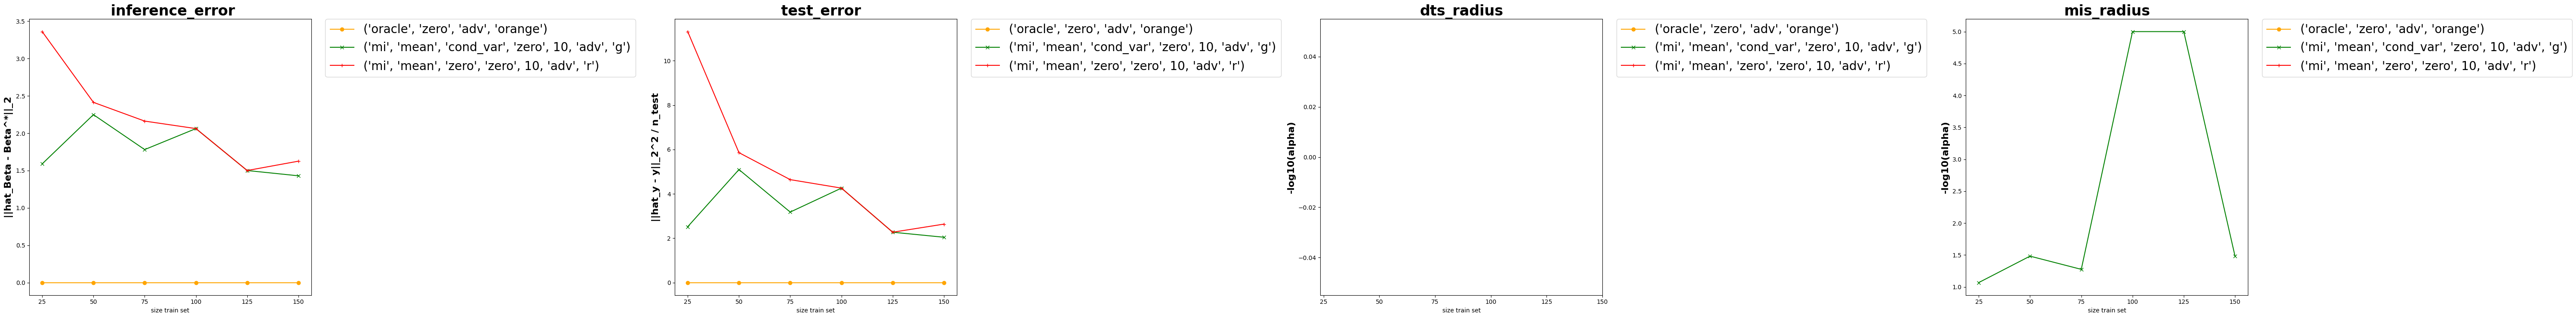

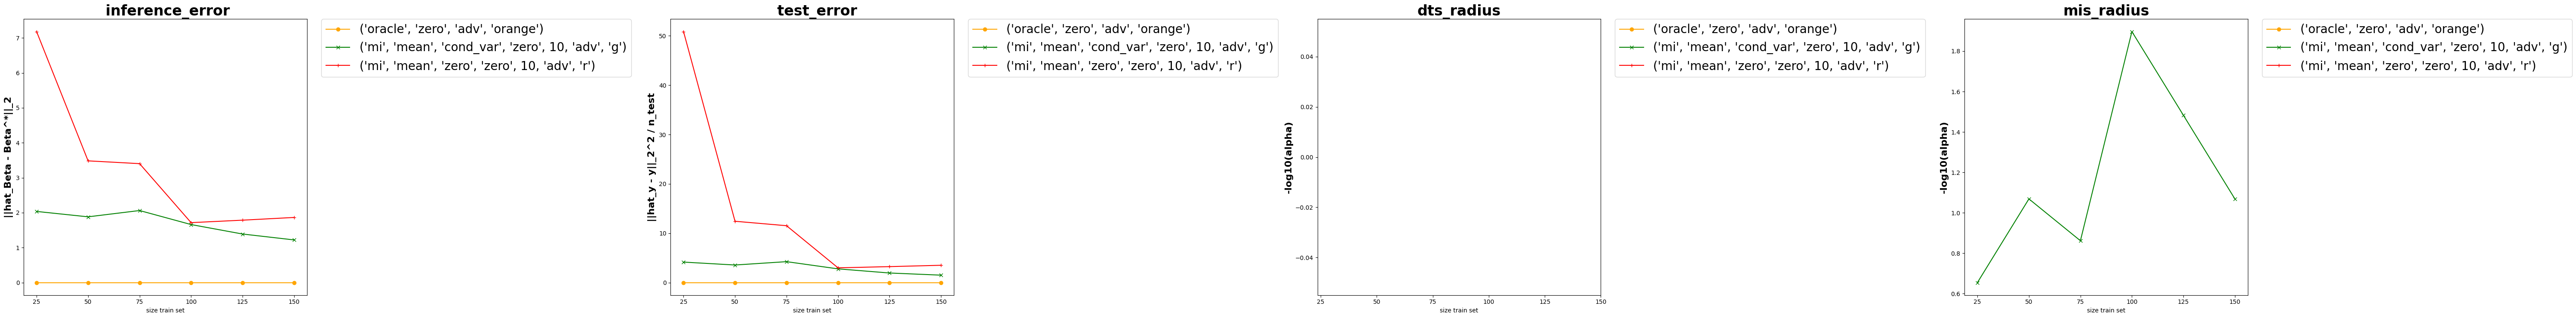

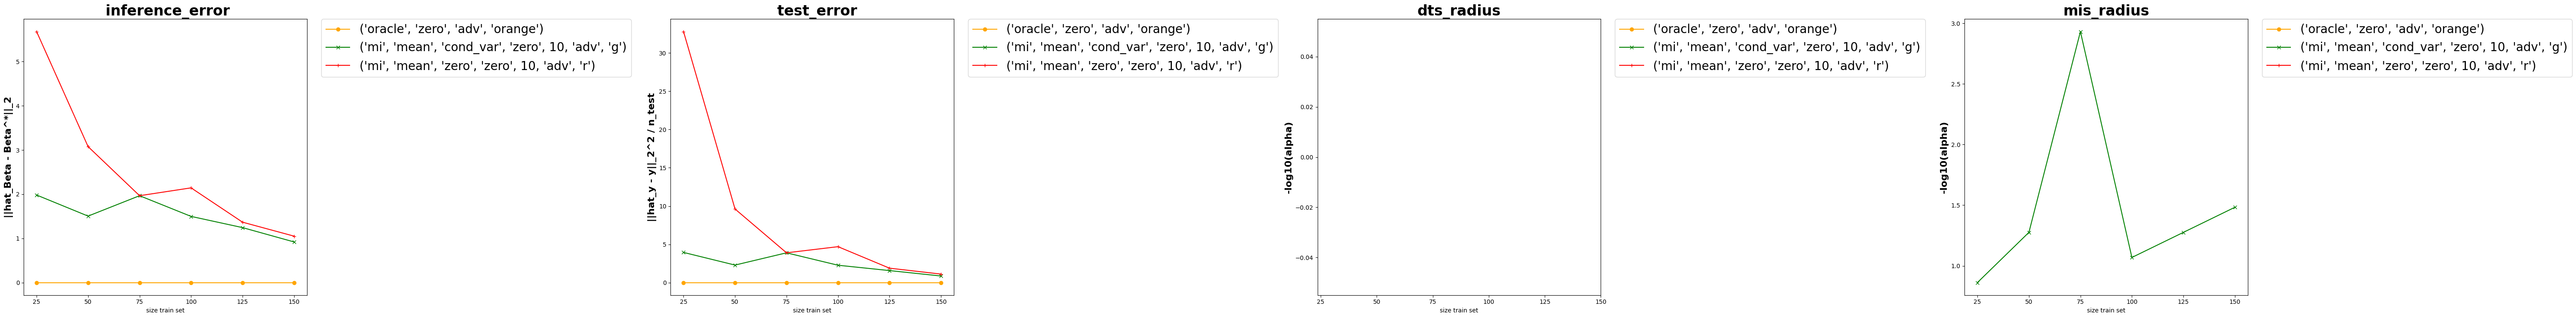

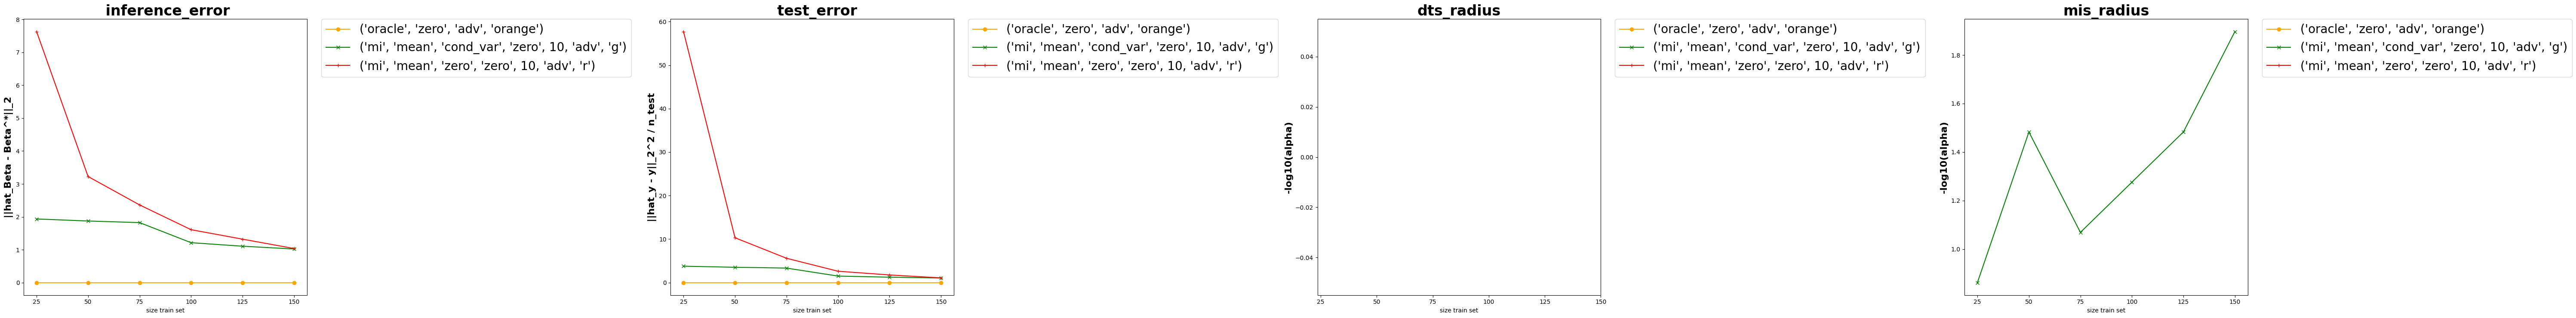

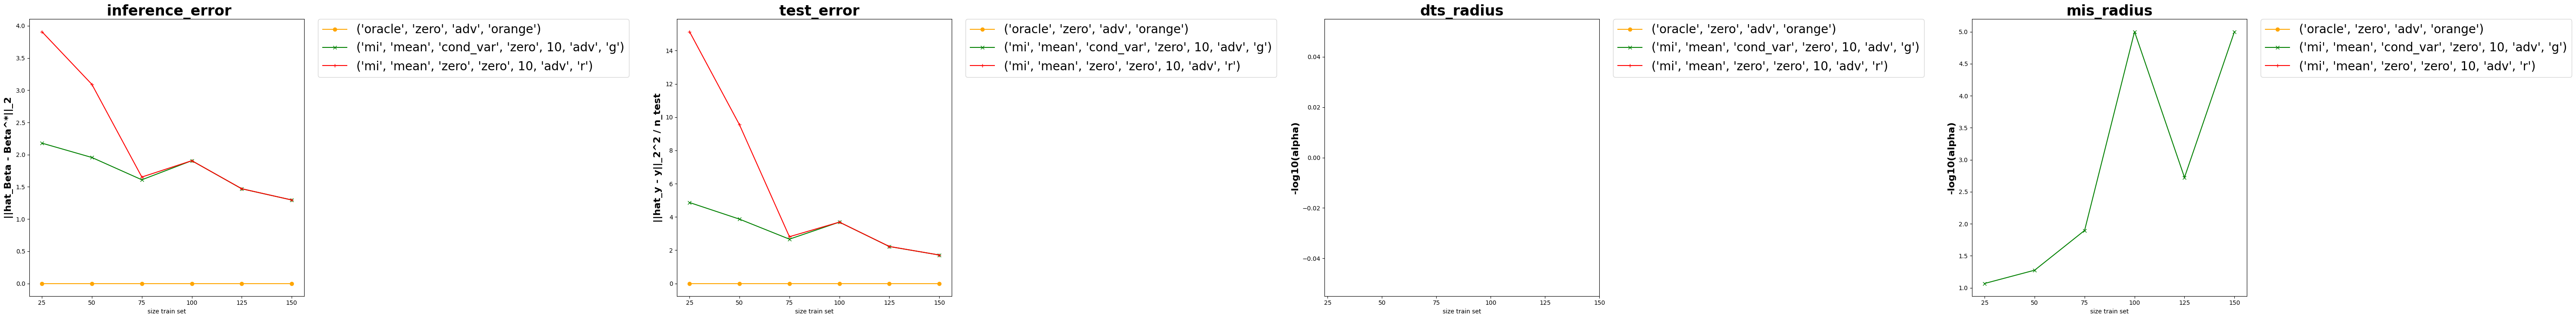

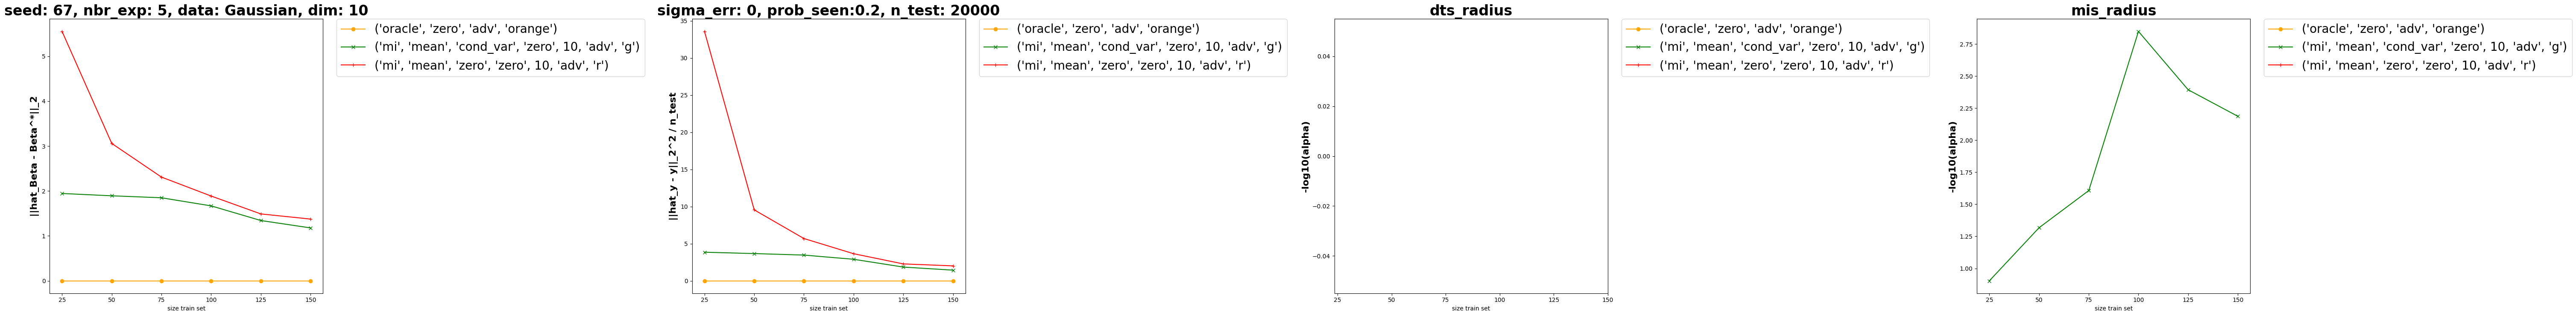

In [36]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'train'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
n_train = [25, 50, 75, 100, 125, 150]  # check how dataset are generated, there should be some problems with 'fixed'
lenght_vec = len(n_train)
p_seen_both = [0.20, 1, 1, 1, 1, 1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error_vec =  [0] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
  fix_vec = 'prob_seen:' + str(p_seen_both[0])
elif info_axis == 'p_seen':
  main_vec = np.cumprod(p_seen_both)  # p_seen_both
  fix_vec = 'n_train:' + str(n_train[0])
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
#cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(10)
print(beta_gt)
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 1
cov = matr.T @ matr + np.eye(dim) * 0.5
# np.array([[1, cov_var], [cov_var, 1]])
data_type = 'Gaussian'

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': data_type, 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts']
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'title_dts_radius': 'dts_radius', 'title_mis_radius': 'mis_radius'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 10, 'alpha_ridge_reg_max': 1,
                             'eps_adv_rad_times_delta_dts': 1e-5, 'eps_adv_rad_times_delta_mis': 1e-6, 'eps_alpha_ridge_reg': 1e-5,
                             'n_a_dts': 30, 'n_a_mis':30, 'n_a_rid': 1}}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 10
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [#{'imp_method': 'BR_si', 'cov_strategy': 'zero', 'algo_superv_learn': 'adv', 'color': 'b'},  #, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'adv'},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'ridge'},  #, 'multip_dataset': 3, 'multip_missing': 0}
                        {'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'adv', 'color': 'orange'},  #, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'g'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'r'}
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''

nbr_exp = 5
seed = 67
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', data: '+ data_type + ', dim: ' + str(dim) # ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', ' + fix_vec + ', n_test: ' + str(number_test)
#dicc['title_dts_radius'] = 'dts_radius'
#dicc['title_mis_radius'] = 'mis_radius'
#dicc = dicc | {'title_dts_radius': 'title_dts_radius', 'title_mis_radius': 'title_mis_radius'}
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
#dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[3 3]
  [3 2]]

 [[2 2]
  [2 4]]]
[[3 3]
 [3 2]
 [2 2]
 [2 4]]
[[[2 4]
  [2 2]
  [4 4]]]
[[2 4]
 [2 2]
 [4 4]]
[[2 2]
 [3 3]
 [2 2]
 [3 4]
 [4 2]]
[2 2 3 3 2 2 3 4 4 2]
other
[2 2 3 3 2]
[2 2 3 3 2 2 2 3 3 2 2 2 3 3 2]
other mult
[[3 5]
 [5 2]
 [3 7]]
[[3 5]
 [5 2]
 [3 7]
 [3 5]
 [5 2]
 [3 7]
 [3 5]
 [5 2]
 [3 7]]


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

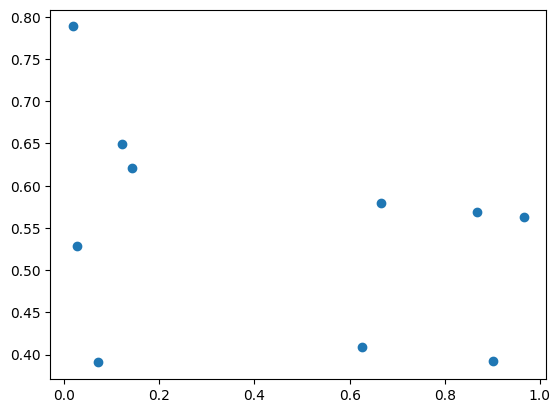

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

#add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


test generate_X started
(1000, 2)
test generate passed syccessfully

test preparation dataset started
X_train 
 [[0.04882641 0.60856921 0.48697528 0.9589182 ]
 [0.08366181 0.87320568 0.53055065 0.14100974]
 [0.72015882 0.1100106  0.46123989 0.52810888]]
mask, 0 seen, 1 missing 
  [[1 1 1 1]
 [1 0 1 1]
 [1 0 1 0]]
X_masked 
 [[0.         0.         0.         0.        ]
 [0.         0.87320568 0.         0.        ]
 [0.         0.1100106  0.         0.52810888]]
X_nan_train 
 [[       nan        nan        nan        nan]
 [       nan 0.87320568        nan        nan]
 [       nan 0.1100106         nan 0.52810888]]
X_br_train
  [[0.49160814 0.52810888]
 [0.87320568 0.52810888]
 [0.1100106  0.52810888]]
what happens if we run single_imputation of full dataset
X_br_full
  [[0.04882641 0.60856921 0.48697528 0.9589182 ]
 [0.08366181 0.87320568 0.53055065 0.14100974]
 [0.72015882 0.1100106  0.46123989 0.52810888]]
test preparation dataset ended successfully

 test list_wise delection start

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


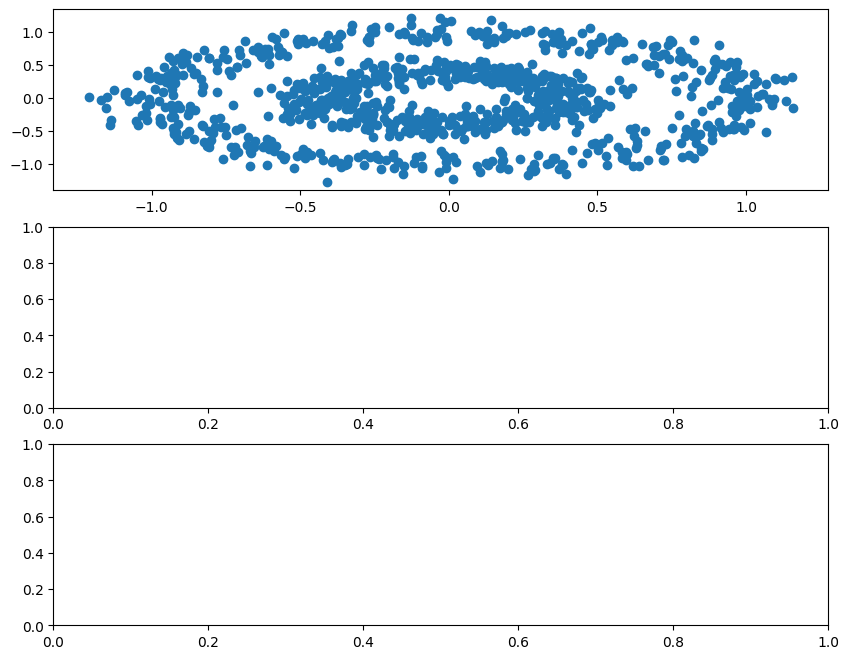

In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




[3]
scores:   [5.38912547e+08 5.39186238e+08 5.39602864e+08 2.12990000e+02
 5.38905603e+08 5.39005102e+08 5.39755881e+08 5.40447503e+08
 5.38746407e+08 5.39169822e+08 5.38682415e+08 5.39975633e+08
 5.39186056e+08 5.39532648e+08 5.39843123e+08 5.38277772e+08
 5.38711888e+08 5.38923404e+08 5.38102460e+08 5.39582688e+08]
best coeff  [3 1 2 4 2]
best score  212.99
test best predictor passed


n:   442 , d:  10


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

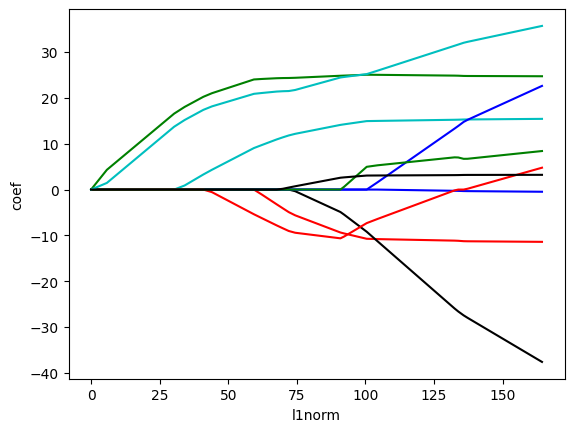

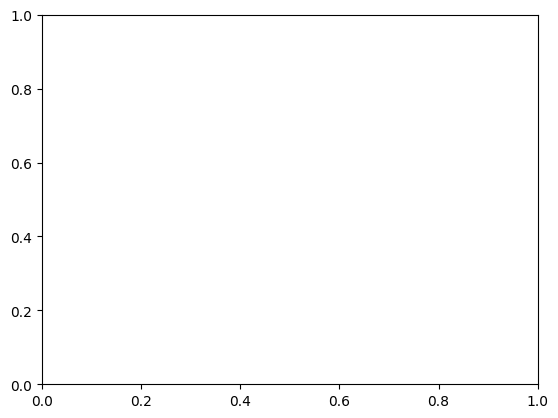

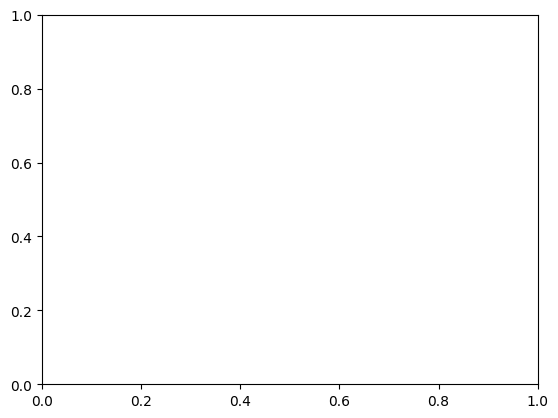

In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)


lg = np.random.logistic(loc=0.0, scale=1.0, size=(4, 3))
print("log res ", lg)

